<a href="https://colab.research.google.com/github/burakakal/Olist_Dataset/blob/main/Olist_Dataset_Finance_Ops_DS_Insight.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

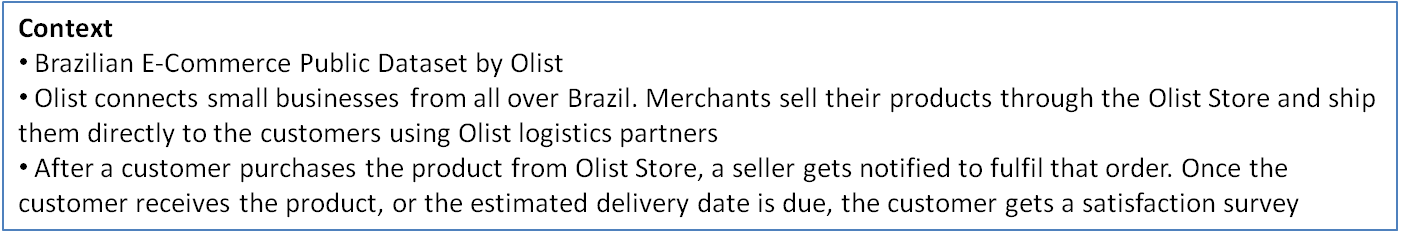

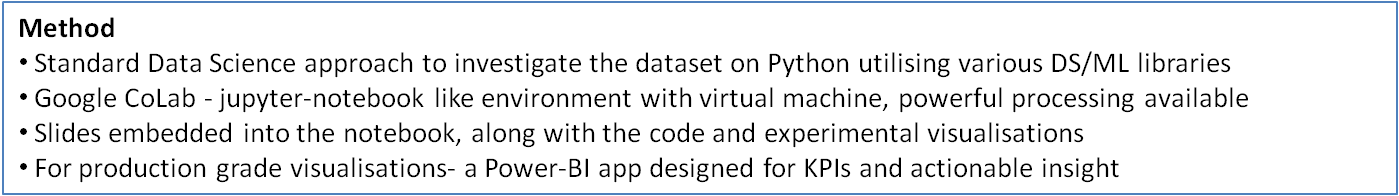

Go through Table of Contents

#### Data Model

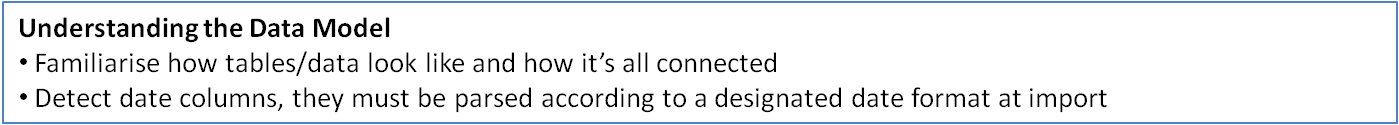

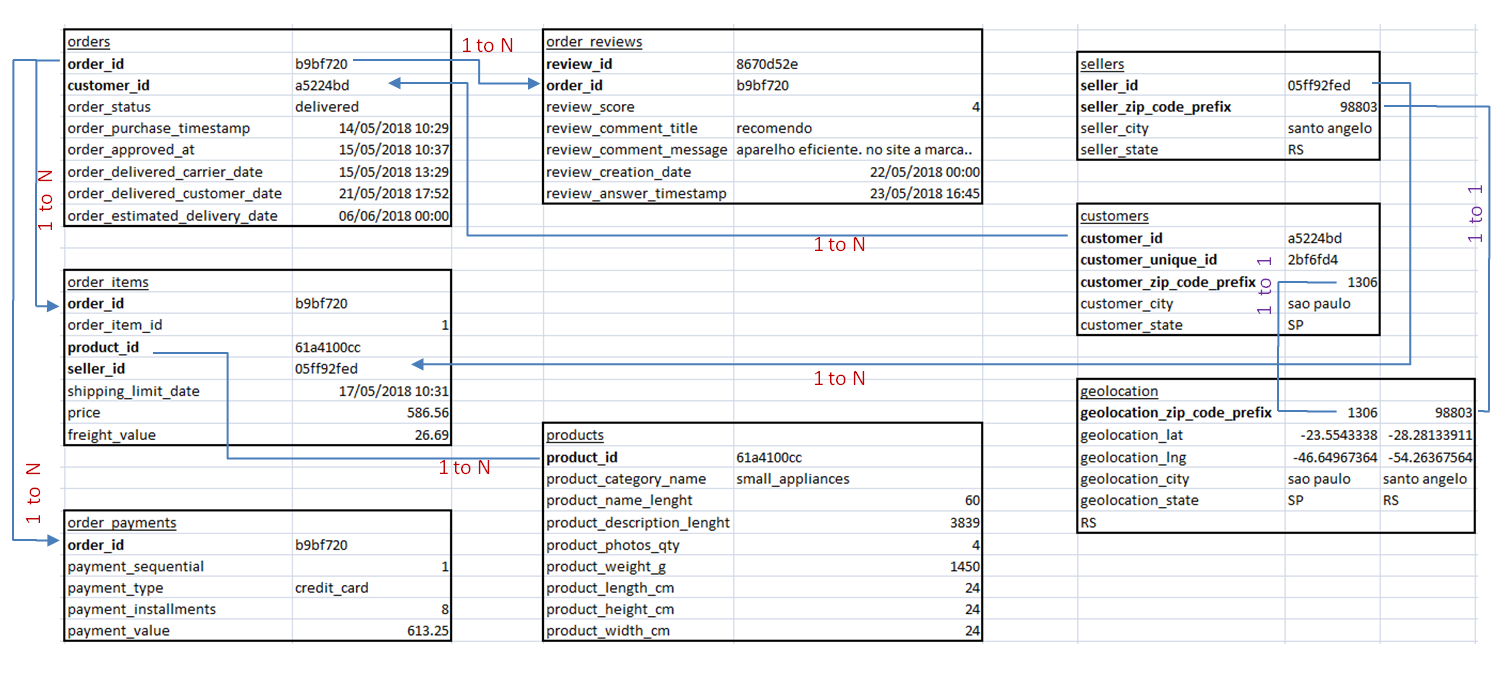

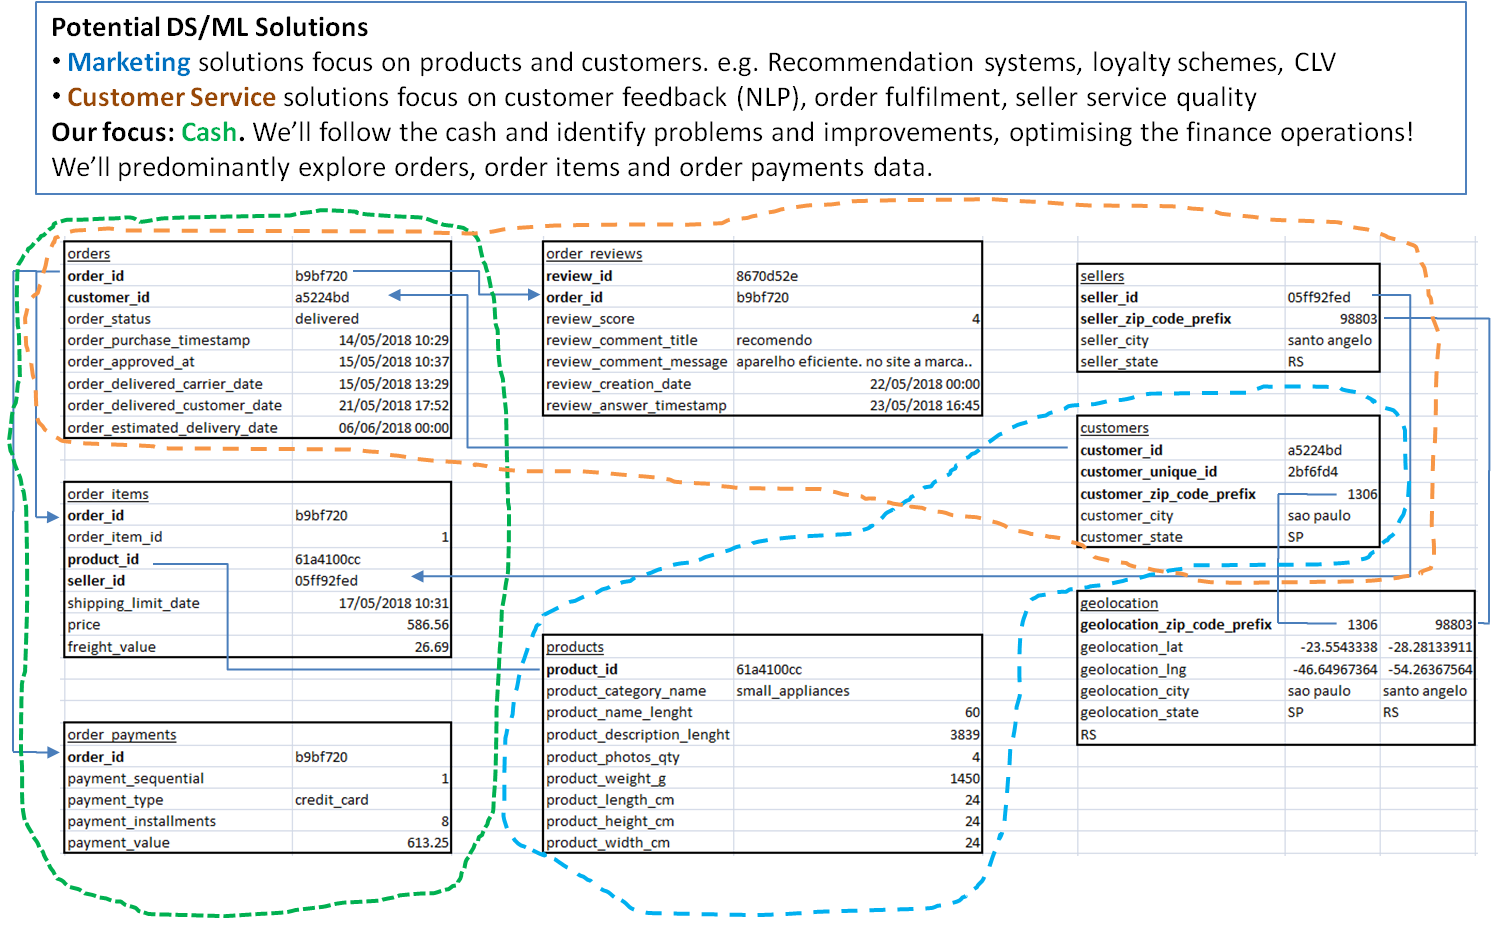

#### Load Data into Dataframes

In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_style("ticks")
import random as rd
!pip install Prophet
from prophet import Prophet
from prophet.serialize import model_to_json, model_from_json
!pip install workalendar
from workalendar.america import Brazil
import itertools
from prophet.diagnostics import cross_validation, performance_metrics
from google.colab import drive
drive.mount('/content/gdrive')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#load data into pandas dataframes, parse date columns
dateparse = lambda x: datetime.datetime.strptime(x, "%Y-%m-%d %H:%M:%S") if pd.notnull(x) else np.NaN
orders = pd.read_csv(r'/content/gdrive/MyDrive/Data_Scientist_Case/olist_orders_dataset.csv', date_parser =dateparse,
                     parse_dates = ['order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date', 'order_estimated_delivery_date', 'order_purchase_timestamp'])

In [ ]:
orders.head(3)

order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
2  47770eb9100c2d0c44946d9cf07ec65d  41ce2a54c0b03bf3443c3d931a367089   

  order_status order_purchase_timestamp   order_approved_at  \
0    delivered      2017-10-02 10:56:33 2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37 2018-07-26 03:24:27   
2    delivered      2018-08-08 08:38:49 2018-08-08 08:55:23   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   
2          2018-08-08 13:50:00           2018-08-17 18:06:29   

  order_estimated_delivery_date  
0                    2017-10-18  
1                    2018-08-13  
2                    2018-09-04

In [ ]:
order_items = pd.read_csv(r'/content/gdrive/MyDrive/Data_Scientist_Case/olist_order_items_dataset.csv', date_parser =dateparse, parse_dates = ['shipping_limit_date'])
order_payments = pd.read_csv(r'/content/gdrive/MyDrive/Data_Scientist_Case/olist_order_payments_dataset.csv')
order_reviews = pd.read_csv(r'/content/gdrive/MyDrive/Data_Scientist_Case/olist_order_reviews_dataset.csv', date_parser =dateparse, parse_dates = ['review_creation_date', 'review_answer_timestamp'])
products = pd.read_csv(r'/content/gdrive/MyDrive/Data_Scientist_Case/olist_products_dataset.csv')
sellers = pd.read_csv(r'/content/gdrive/MyDrive/Data_Scientist_Case/olist_sellers_dataset.csv')
customers = pd.read_csv(r'/content/gdrive/MyDrive/Data_Scientist_Case/olist_customers_dataset.csv')
geolocation = pd.read_csv(r'/content/gdrive/MyDrive/Data_Scientist_Case/olist_geolocation_dataset.csv')
product_categories_english = pd.read_csv(r'/content/gdrive/MyDrive/Data_Scientist_Case/product_category_name_translation.csv')

#### Data Validation and Cleanup

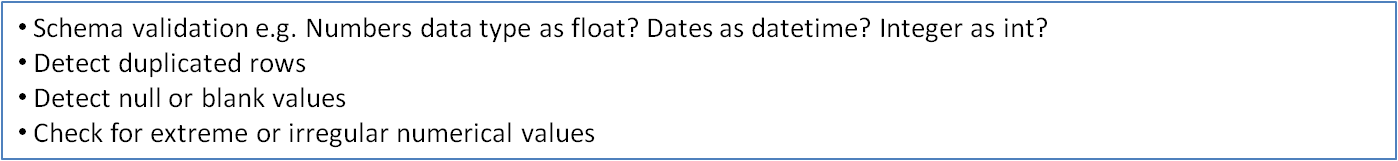

In [ ]:
# loop thru all dataframes to detect wrong data types, nulls, ranges etc.
for df in [orders, order_items, order_payments, order_reviews, order_reviews, sellers, customers, geolocation, product_categories_english]:
  display_row = rd.randint(5, len(df)-3)
  display(df.iloc[display_row:display_row+3])
  print('\n')
  print(df.dtypes)
  print('\n')
  display(df.describe())
  print('\n')
  print(f'includes {df.duplicated().sum()} duplicated rows')
  print('\n')
  print('Are there any nulls by column?')
  print(df.isnull().sum())
  print('\n')

order_id                       customer_id  \
53190  db7059aeda4a4b33b40700c87731ae15  c5e87e44425d8b1adc3650af46744779   
53191  fa7e8db523dd1cd2956e294889d6e611  27485717197b3f06c3c7186afd687382   
53192  7889ce550f16a1fe103ffcf2a4a537c2  28d5ddbe17cf2c62357a3e08db9d6c47   

      order_status order_purchase_timestamp   order_approved_at  \
53190    delivered      2018-06-06 01:54:04 2018-06-06 02:13:09   
53191    delivered      2018-02-27 08:33:25 2018-02-28 09:36:22   
53192    delivered      2018-02-22 15:03:09 2018-02-22 15:30:40   

      order_delivered_carrier_date order_delivered_customer_date  \
53190          2018-06-06 12:34:00           2018-06-16 17:14:37   
53191          2018-03-02 02:22:55           2018-03-08 21:38:32   
53192          2018-02-28 18:48:45           2018-03-08 01:09:19   

      order_estimated_delivery_date  
53190                    2018-07-17  
53191                    2018-03-22  
53192                    2018-03-14



order_id                                 object
customer_id                              object
order_status                             object
order_purchase_timestamp         datetime64[ns]
order_approved_at                datetime64[ns]
order_delivered_carrier_date     datetime64[ns]
order_delivered_customer_date    datetime64[ns]
order_estimated_delivery_date    datetime64[ns]
dtype: object




order_id                       customer_id  \
count                              99441                             99441   
unique                             99441                             99441   
top     e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
freq                                   1                                 1   
first                                NaN                               NaN   
last                                 NaN                               NaN   

       order_status order_purchase_timestamp    order_approved_at  \
count         99441                    99441                99281   
unique            8                    98875                90733   
top       delivered      2018-04-11 10:48:14  2018-02-27 04:31:10   
freq          96478                        3                    9   
first           NaN      2016-09-04 21:15:19  2016-09-15 12:16:38   
last            NaN      2018-10-17 17:30:18  2018-09-03 17:40:06   

       order_delivered_carrier_date order_delivered_customer_date  \
count                         97658                         96476   
unique                        81018                         95664   
top             2018-05-09 15:48:00           2018-05-08 23:38:46   
freq                             47                             3   
first           2016-10-08 10:34:01           2016-10-11 13:46:32   
last            2018-09-11 19:48:28           2018-10-17 13:22:46   

       order_estimated_delivery_date  
count                          99441  
unique                           459  
top              2017-12-20 00:00:00  
freq                             522  
first            2016-09-30 00:00:00  
last             2018-11-12 00:00:00



includes 0 duplicated rows


Are there any nulls by column?
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64




order_id  order_item_id  \
19521  2ccc09c6c27e9be6d9723883f81ffeef              1   
19522  2ccc09c6c27e9be6d9723883f81ffeef              2   
19523  2ccc4454c10457bb1cd9fb7465167f2f              1   

                             product_id                         seller_id  \
19521  854f1672c41eaa84b3e3a79e06146f63  ea8482cd71df3c1969d7b9473ff13abc   
19522  854f1672c41eaa84b3e3a79e06146f63  ea8482cd71df3c1969d7b9473ff13abc   
19523  183c95ad186f48c320bbac4643829d3f  cab85505710c7cb9b720bceb52b01cee   

      shipping_limit_date  price  freight_value  
19521 2018-04-23 21:51:58  24.99          18.23  
19522 2018-04-23 21:51:58  24.99          18.23  
19523 2018-08-21 15:04:07  49.90           7.61



order_id                       object
order_item_id                   int64
product_id                     object
seller_id                      object
shipping_limit_date    datetime64[ns]
price                         float64
freight_value                 float64
dtype: object




order_item_id          price  freight_value
count  112650.000000  112650.000000  112650.000000
mean        1.197834     120.653739      19.990320
std         0.705124     183.633928      15.806405
min         1.000000       0.850000       0.000000
25%         1.000000      39.900000      13.080000
50%         1.000000      74.990000      16.260000
75%         1.000000     134.900000      21.150000
max        21.000000    6735.000000     409.680000



includes 0 duplicated rows


Are there any nulls by column?
order_id               0
order_item_id          0
product_id             0
seller_id              0
shipping_limit_date    0
price                  0
freight_value          0
dtype: int64




order_id  payment_sequential payment_type  \
69655  38ab7ca6747531f5173881e11be23b74                   1  credit_card   
69656  ad369c5a6bd2534d48420216de8fd8f5                   1  credit_card   
69657  19feb5627c41ea1b36a8e50a469b3644                   1  credit_card   

       payment_installments  payment_value  
69655                     6         156.82  
69656                     2          63.10  
69657                     9         212.32



order_id                 object
payment_sequential        int64
payment_type             object
payment_installments      int64
payment_value           float64
dtype: object




payment_sequential  payment_installments  payment_value
count       103886.000000         103886.000000  103886.000000
mean             1.092679              2.853349     154.100380
std              0.706584              2.687051     217.494064
min              1.000000              0.000000       0.000000
25%              1.000000              1.000000      56.790000
50%              1.000000              1.000000     100.000000
75%              1.000000              4.000000     171.837500
max             29.000000             24.000000   13664.080000



includes 0 duplicated rows


Are there any nulls by column?
order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64




review_id                          order_id  \
25372  c715563d042b06679e208cafb6d0d205  57323a7f9df2ab8eabf8fb751d3f2334   
25373  6370f680af88c3cb8db738223651c329  dee5aaea45b39a487724b13ee9523e88   
25374  518969855d1e4d2de30cc151d593573e  30c5c38cb890960278d9a04521f5fff7   

       review_score review_comment_title  review_comment_message  \
25372             4                  NaN                     NaN   
25373             5                  NaN                     NaN   
25374             5                  NaN  ok, conforme combinado   

      review_creation_date review_answer_timestamp  
25372           2018-06-13     2018-06-14 03:12:47  
25373           2018-02-06     2018-02-09 09:17:18  
25374           2017-12-22     2017-12-27 13:18:12



review_id                          object
order_id                           object
review_score                        int64
review_comment_title               object
review_comment_message             object
review_creation_date       datetime64[ns]
review_answer_timestamp    datetime64[ns]
dtype: object




review_score
count  99224.000000
mean       4.086421
std        1.347579
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000



includes 0 duplicated rows


Are there any nulls by column?
review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64




review_id                          order_id  \
79541  5f564429f68da71e4daa345982bbcd57  9a9a504bd8c303044422d2ca234992d1   
79542  8643353366228abba19f76c08979a06e  79f92b33bbe0c43264104fc5ee0b10b2   
79543  f71d71c00c991681760985e775def686  e808b609d07ef4f022d702b20db24137   

       review_score review_comment_title  \
79541             2                  NaN   
79542             4                  NaN   
79543             4                  NaN   

                                  review_comment_message review_creation_date  \
79541       Sem localização do produto. Entrega atrasada           2018-03-07   
79542                                                NaN           2018-05-19   
79543  Durante a compra não encontrei a opção de alte...           2018-01-28   

      review_answer_timestamp  
79541     2018-03-09 03:22:17  
79542     2018-05-23 00:33:09  
79543     2018-01-28 11:21:19



review_id                          object
order_id                           object
review_score                        int64
review_comment_title               object
review_comment_message             object
review_creation_date       datetime64[ns]
review_answer_timestamp    datetime64[ns]
dtype: object




review_score
count  99224.000000
mean       4.086421
std        1.347579
min        1.000000
25%        4.000000
50%        5.000000
75%        5.000000
max        5.000000



includes 0 duplicated rows


Are there any nulls by column?
review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64




seller_id  seller_zip_code_prefix seller_city  \
2169  0d85bbda9889ce1f7e63778d24f346eb                   38414  uberlandia   
2170  4c61e37f664c3c88aff092aa5ac779d7                   24020     niteroi   
2171  b44dbfbf62e52125f3c15d230569ea91                    4251   sao paulo   

     seller_state  
2169           MG  
2170           RJ  
2171           SP



seller_id                 object
seller_zip_code_prefix     int64
seller_city               object
seller_state              object
dtype: object




seller_zip_code_prefix
count             3095.000000
mean             32291.059451
std              32713.453830
min               1001.000000
25%               7093.500000
50%              14940.000000
75%              64552.500000
max              99730.000000



includes 0 duplicated rows


Are there any nulls by column?
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64




customer_id                customer_unique_id  \
5290  91f797f3971210009f7b9261a82b8939  1664dbb811a17747439f7a1126173ccc   
5291  cfedf8fc9bf6108c3fd34514c00be6aa  76c9a12722537319e44c31e70b7815c3   
5292  e4187e722cbd5b6db4b0c68b68b8c573  7675ea22236da5d26f0d27950f7fd3fa   

      customer_zip_code_prefix       customer_city customer_state  
5290                     38840  carmo do paranaiba             MG  
5291                     13960             socorro             SP  
5292                     39530  rio pardo de minas             MG



customer_id                 object
customer_unique_id          object
customer_zip_code_prefix     int64
customer_city               object
customer_state              object
dtype: object




customer_zip_code_prefix
count              99441.000000
mean               35137.474583
std                29797.938996
min                 1003.000000
25%                11347.000000
50%                24416.000000
75%                58900.000000
max                99990.000000



includes 0 duplicated rows


Are there any nulls by column?
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64




geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
918979                        88802       -28.682732       -49.370422   
918980                        88880       -28.387424       -49.390527   
918981                        88845       -28.586434       -49.318655   

       geolocation_city geolocation_state  
918979         criciuma                SC  
918980     lauro muller                SC  
918981     cocal do sul                SC



geolocation_zip_code_prefix      int64
geolocation_lat                float64
geolocation_lng                float64
geolocation_city                object
geolocation_state               object
dtype: object




geolocation_zip_code_prefix  geolocation_lat  geolocation_lng
count                 1.000163e+06     1.000163e+06     1.000163e+06
mean                  3.657417e+04    -2.117615e+01    -4.639054e+01
std                   3.054934e+04     5.715866e+00     4.269748e+00
min                   1.001000e+03    -3.660537e+01    -1.014668e+02
25%                   1.107500e+04    -2.360355e+01    -4.857317e+01
50%                   2.653000e+04    -2.291938e+01    -4.663788e+01
75%                   6.350400e+04    -1.997962e+01    -4.376771e+01
max                   9.999000e+04     4.506593e+01     1.211054e+02



includes 261831 duplicated rows


Are there any nulls by column?
geolocation_zip_code_prefix    0
geolocation_lat                0
geolocation_lng                0
geolocation_city               0
geolocation_state              0
dtype: int64




product_category_name          product_category_name_english
61                       musica                                  music
62              casa_conforto_2                         home_comfort_2
63  portateis_casa_forno_e_cafe  small_appliances_home_oven_and_coffee



product_category_name            object
product_category_name_english    object
dtype: object




product_category_name product_category_name_english
count                     71                            71
unique                    71                            71
top             beleza_saude                 health_beauty
freq                       1                             1



includes 0 duplicated rows


Are there any nulls by column?
product_category_name            0
product_category_name_english    0
dtype: int64




In [ ]:
# geolocation table is way too big, close inspection shows key column "geolocation_zip_code_prefix" is duplicated
# remove duplicates to have unique rows against the key
display(geolocation.sort_values('geolocation_zip_code_prefix').head(3))

geolocation.drop_duplicates(subset='geolocation_zip_code_prefix', inplace=True)
geolocation.reset_index(inplace=True, drop = True)

display(geolocation.sort_values('geolocation_zip_code_prefix').head(3))
print(f'includes {geolocation.duplicated().sum()} duplicated rows')

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
1246                         1001       -23.549292       -46.633559   
429                          1001       -23.550498       -46.634338   
1182                         1001       -23.549779       -46.633957   

     geolocation_city geolocation_state  
1246        sao paulo                SP  
429         sao paulo                SP  
1182        sao paulo                SP

geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
37                         1001       -23.549292       -46.633559   
31                         1002       -23.548318       -46.635421   
36                         1003       -23.549032       -46.635313   

   geolocation_city geolocation_state  
37        sao paulo                SP  
31        sao paulo                SP  
36        sao paulo                SP

includes 0 duplicated rows


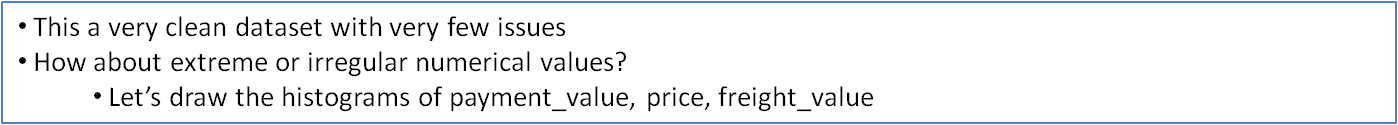

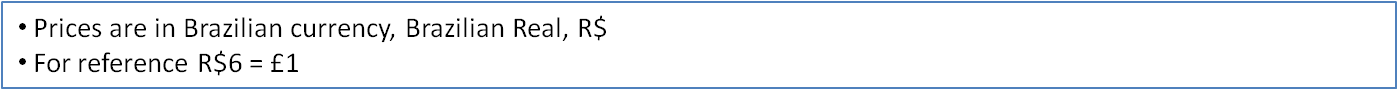

count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64

Number of zeros: 9     99th percentile: 1039.9164999999994     999th percentile: 2339.2332500000343 


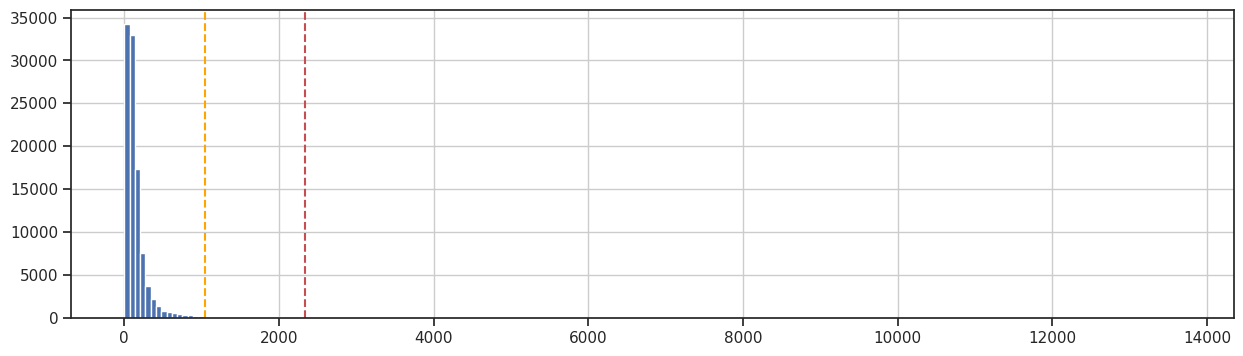

In [ ]:
order_payments['payment_value'].hist(bins=200, figsize=(15, 4),)
percentile_99 = order_payments['payment_value'].quantile(0.99); percentile_999 = order_payments['payment_value'].quantile(0.999); num_of_zeros = sum(order_payments['payment_value']==0)
plt.axvline(x = percentile_99, color = 'orange', ls= '--')
plt.axvline(x = percentile_999, color = 'r', ls= '--')
display(order_payments['payment_value'].describe());
print(f'Number of zeros: {num_of_zeros}     99th percentile: {percentile_99}     999th percentile: {percentile_999} ');

In [ ]:
# Deep dive into the largest payment value
order_payments.sort_values('payment_value',ascending=False).iloc[0]

order_id                03caa2c082116e1d31e67e9ae3700499
payment_sequential                                     1
payment_type                                 credit_card
payment_installments                                   1
payment_value                                   13664.08
Name: 52107, dtype: object

In [ ]:
# Looks legit, bought lots of the same expensive product
order_items[order_items.order_id =='03caa2c082116e1d31e67e9ae3700499']

order_id  order_item_id  \
1647  03caa2c082116e1d31e67e9ae3700499              1   
1648  03caa2c082116e1d31e67e9ae3700499              2   
1649  03caa2c082116e1d31e67e9ae3700499              3   
1650  03caa2c082116e1d31e67e9ae3700499              4   
1651  03caa2c082116e1d31e67e9ae3700499              5   
1652  03caa2c082116e1d31e67e9ae3700499              6   
1653  03caa2c082116e1d31e67e9ae3700499              7   
1654  03caa2c082116e1d31e67e9ae3700499              8   

                            product_id                         seller_id  \
1647  5769ef0a239114ac3a854af00df129e4  b37c4c02bda3161a7546a4e6d222d5b2   
1648  5769ef0a239114ac3a854af00df129e4  b37c4c02bda3161a7546a4e6d222d5b2   
1649  5769ef0a239114ac3a854af00df129e4  b37c4c02bda3161a7546a4e6d222d5b2   
1650  5769ef0a239114ac3a854af00df129e4  b37c4c02bda3161a7546a4e6d222d5b2   
1651  5769ef0a239114ac3a854af00df129e4  b37c4c02bda3161a7546a4e6d222d5b2   
1652  5769ef0a239114ac3a854af00df129e4  b37c4c02bda3161a7546a4e6d222d5b2   
1653  5769ef0a239114ac3a854af00df129e4  b37c4c02bda3161a7546a4e6d222d5b2   
1654  5769ef0a239114ac3a854af00df129e4  b37c4c02bda3161a7546a4e6d222d5b2   

     shipping_limit_date   price  freight_value  
1647 2017-10-06 15:28:20  1680.0          28.01  
1648 2017-10-06 15:28:20  1680.0          28.01  
1649 2017-10-06 15:28:20  1680.0          28.01  
1650 2017-10-06 15:28:20  1680.0          28.01  
1651 2017-10-06 15:28:20  1680.0          28.01  
1652 2017-10-06 15:28:20  1680.0          28.01  
1653 2017-10-06 15:28:20  1680.0          28.01  
1654 2017-10-06 15:28:20  1680.0          28.01

In [ ]:
# Deep dive into zero payment values
# Look legit, very small voucher payments of split payments
# Once aggragated will not be a problem
order_payments[order_payments['payment_value'] == 0]

order_id  payment_sequential payment_type  \
19922   8bcbe01d44d147f901cd3192671144db                   4      voucher   
36822   fa65dad1b0e818e3ccc5cb0e39231352                  14      voucher   
43744   6ccb433e00daae1283ccc956189c82ae                   4      voucher   
51280   4637ca194b6387e2d538dc89b124b0ee                   1  not_defined   
57411   00b1cb0320190ca0daa2c88b35206009                   1  not_defined   
62674   45ed6e85398a87c253db47c2d9f48216                   3      voucher   
77885   fa65dad1b0e818e3ccc5cb0e39231352                  13      voucher   
94427   c8c528189310eaa44a745b8d9d26908b                   1  not_defined   
100766  b23878b3e8eb4d25a158f57d96331b18                   4      voucher   

        payment_installments  payment_value  
19922                      1            0.0  
36822                      1            0.0  
43744                      1            0.0  
51280                      1            0.0  
57411                      1            0.0  
62674                      1            0.0  
77885                      1            0.0  
94427                      1            0.0  
100766                     1            0.0

<Axes: >

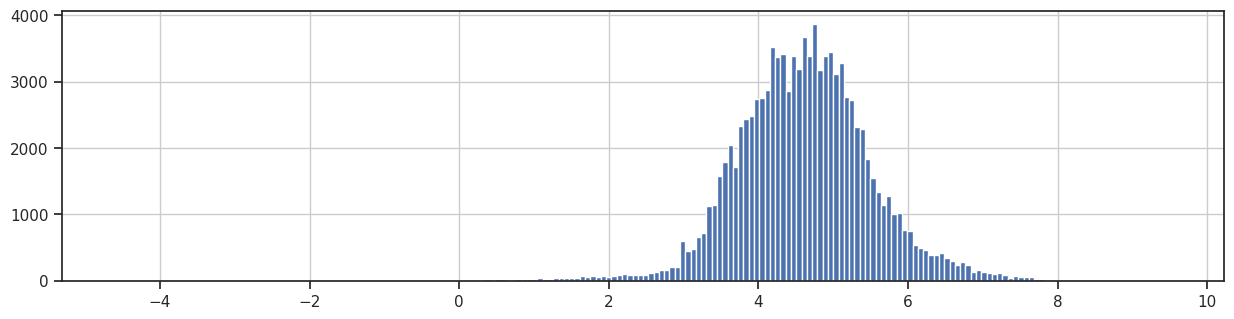

In [ ]:
# Payment/price data is best analysed after log transformation. Should look normally distributed, ish.
test_series = order_payments['payment_value'].apply(lambda x: np.log(x) if x > 0 else np.NaN)
test_series.hist(bins=200, figsize=(15, 3.5),)

<Axes: >

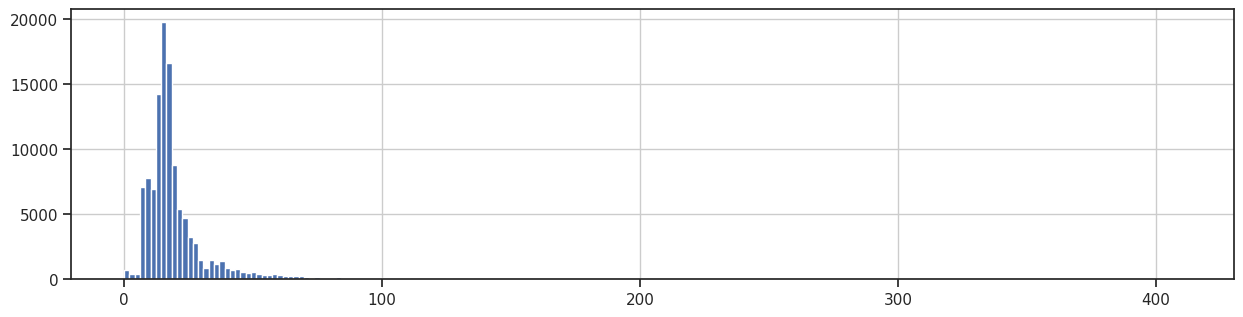

In [ ]:
#'freight_value' has mostly a minimum rate, hence the gap near 0
order_items['freight_value'].hist(bins=200, figsize=(15, 3.5),)

<Axes: >

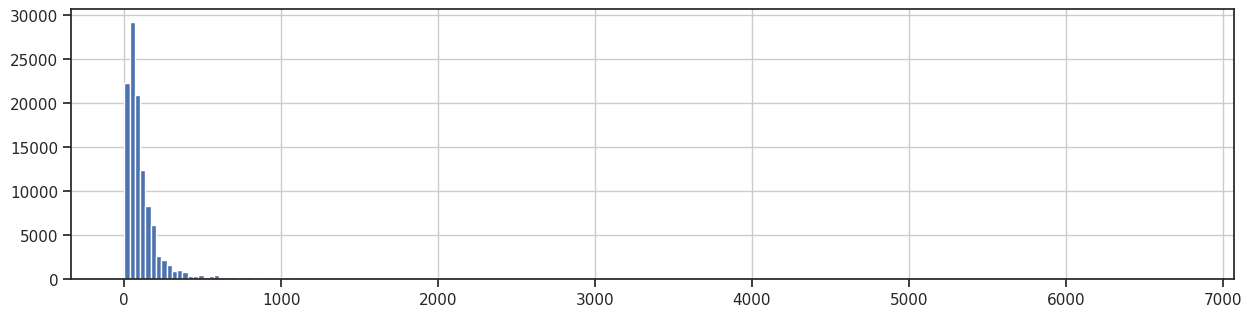

In [ ]:
order_items['price'].hist(bins=200, figsize=(15, 3.5),)

<Axes: >

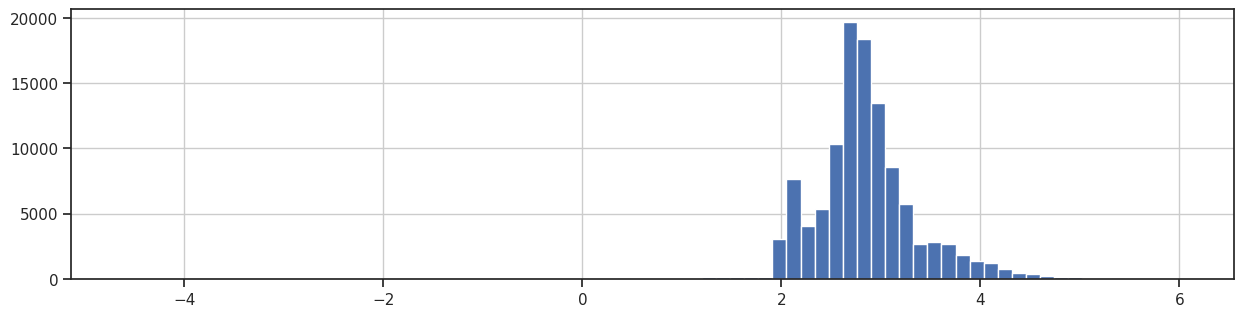

In [ ]:
test_series = order_items['freight_value'].apply(lambda x: np.log(x) if x > 0 else np.NaN); test_series.hist(bins=75, figsize=(15, 3.5),)

<Axes: >

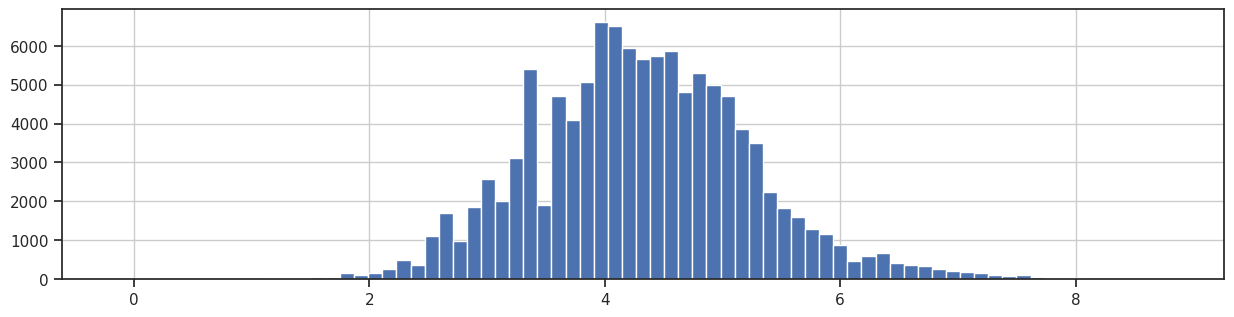

In [ ]:
test_series = order_items['price'].apply(lambda x: np.log(x) if x > 0 else np.NaN); test_series.hist(bins=75, figsize=(15, 3.5),)

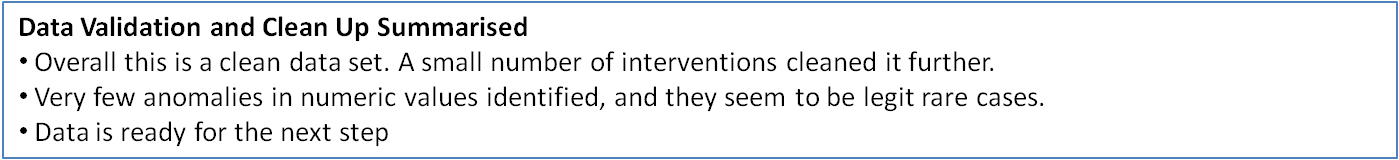

#### Exploratory Data Analysis

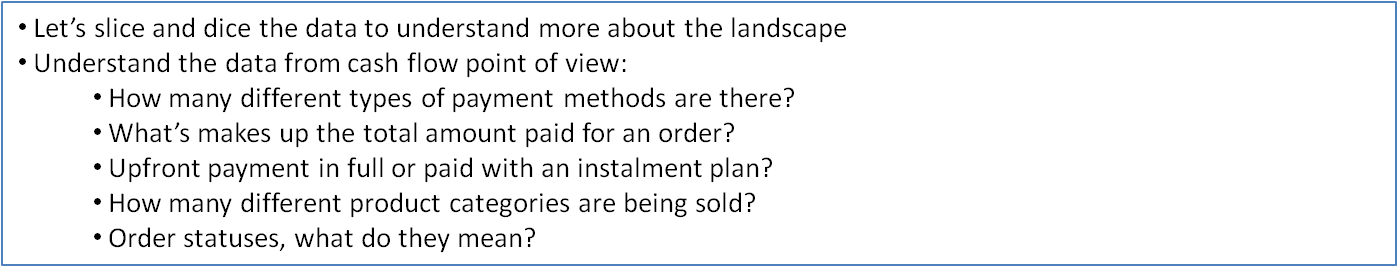

In [ ]:
order_payments.sample(5)

order_id  payment_sequential payment_type  \
18869  484dca40df3d3e143c32574fc87387ca                   1  credit_card   
85733  4bef799000dee0ad92c4b0397f9d16ed                   1  credit_card   
83816  8ec5d698b2bb14e2cb3e4d4f90423a87                   2      voucher   
51119  df88a8395fa16611947484e283503cb3                   1  credit_card   
21972  ab21d46cb0d123ea937d107425f82829                   1  credit_card   

       payment_installments  payment_value  
18869                     1          97.34  
85733                     4         161.23  
83816                     1         197.70  
51119                     1          36.59  
21972                     6          66.07

In [ ]:
# Split payments, how often?
testing_series = order_payments[['order_id', 'payment_sequential']].groupby('order_id').max()
pd.DataFrame(testing_series.value_counts(normalize=True),columns = ['volume']).head(5)

volume
payment_sequential          
1                   0.969439
2                   0.024718
3                   0.003047
4                   0.001086
5                   0.000523

In [ ]:
order_payments[order_payments['order_id'] == '00bd50cdd31bd22e9081e6e2d5b3577b']

order_id  payment_sequential payment_type  \
8869   00bd50cdd31bd22e9081e6e2d5b3577b                   3      voucher   
20650  00bd50cdd31bd22e9081e6e2d5b3577b                   2      voucher   
34559  00bd50cdd31bd22e9081e6e2d5b3577b                   1  credit_card   

       payment_installments  payment_value  
8869                      1          40.46  
20650                     1          40.46  
34559                     1           4.88

About 97% of the orders were paid with single payment transaction. Remaining 3% split into multiple, e.g. Credit Card + Voucher

When there's multiple payment transactions, this table will show multiple rows. Consider while doing joins later, first need to aggregate

In [ ]:
#helper function for pie chart format
def autopct_format(values):
        def my_format(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            #return '{:.1f}%\n({v:d})'.format(pct, v=val)
            if pct > 0.05: return '{:.1f}%'.format(pct, v=val)
            else: return ''
        return my_format

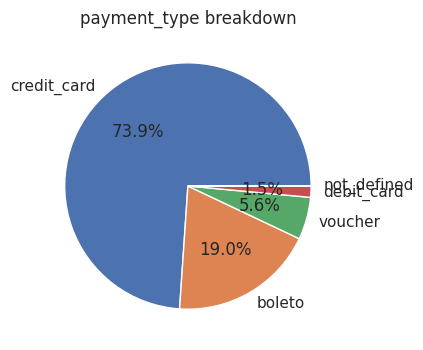

In [ ]:
# Let's explore payment type breakdown
series = order_payments['payment_type'].value_counts(normalize=True)
plt.pie(series,labels = series.index, autopct=autopct_format(series)); plt.title('payment_type breakdown');

Most common is credit card at 74% but other methods, like boleto at 19% are common too

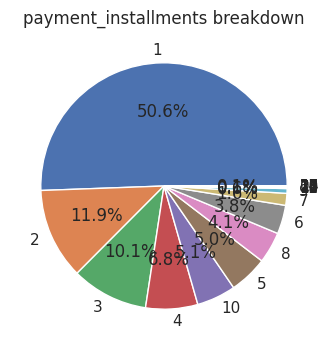

In [ ]:
#Explore paid upfront or installment plan
series = order_payments['payment_installments'].value_counts(normalize=True)
plt.pie(series,labels = series.index, autopct=autopct_format(series)); plt.title('payment_installments breakdown');

Only half of the payments paid the order in full upfront. The other half used an installment plan, this has important implications when it comes to cash receipts!

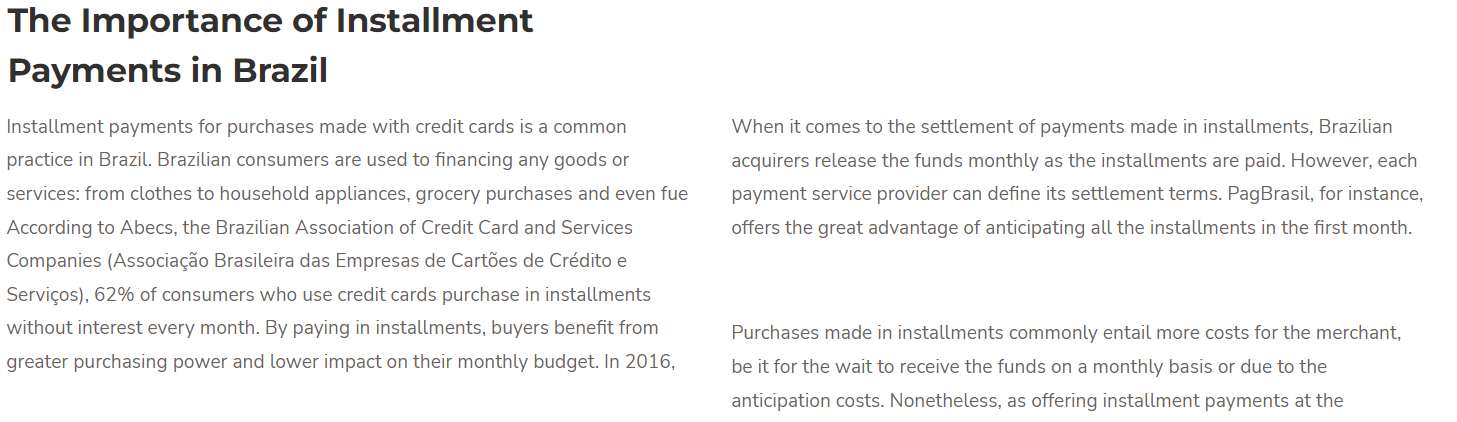

[Source hyperlink](https://www.pagbrasil.com/news/installment-payments-brazil/)

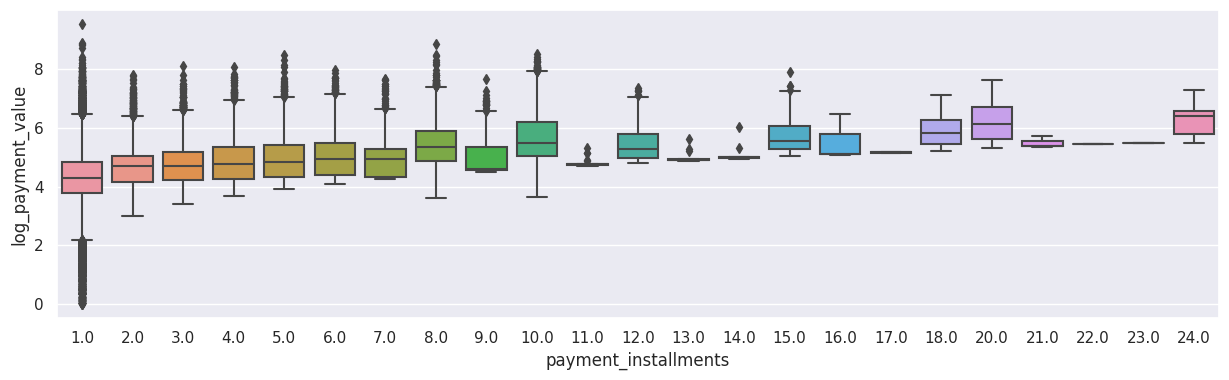

In [ ]:
# Larger payments more likely to be instalment plans?
df= pd.DataFrame()
df['log_payment_value'] = order_payments['payment_value'].apply(lambda x: np.log(x) if x>0 and np.log(x)>0 else np.NaN)
df['payment_installments'] = order_payments['payment_installments'].apply(lambda x: np.NaN if x == 0 else x)
sns.set(rc={'figure.figsize':(15,4)}); sns.boxplot(x='payment_installments', y='log_payment_value', data=df);

It seems largers payments are indeed more likely to be paid in installment plans
Also there seems to be a minimum limit before installment plans become available to customer

In [ ]:
# Let's take investigate payment types and instalment plans together
df = pd.pivot_table(order_payments[['payment_type', 'payment_installments']], values='payment_type', index=['payment_type', 'payment_installments'],
                       aggfunc={'payment_type': "count"}); df.columns = ['count_of_payments']; df.reset_index(inplace=True)
display(df)

payment_type  payment_installments  count_of_payments
0        boleto                     1              19784
1   credit_card                     0                  2
2   credit_card                     1              25455
3   credit_card                     2              12413
4   credit_card                     3              10461
5   credit_card                     4               7098
6   credit_card                     5               5239
7   credit_card                     6               3920
8   credit_card                     7               1626
9   credit_card                     8               4268
10  credit_card                     9                644
11  credit_card                    10               5328
12  credit_card                    11                 23
13  credit_card                    12                133
14  credit_card                    13                 16
15  credit_card                    14                 15
16  credit_card                    15                 74
17  credit_card                    16                  5
18  credit_card                    17                  8
19  credit_card                    18                 27
20  credit_card                    20                 17
21  credit_card                    21                  3
22  credit_card                    22                  1
23  credit_card                    23                  1
24  credit_card                    24                 18
25   debit_card                     1               1529
26  not_defined                     1                  3
27      voucher                     1               5775

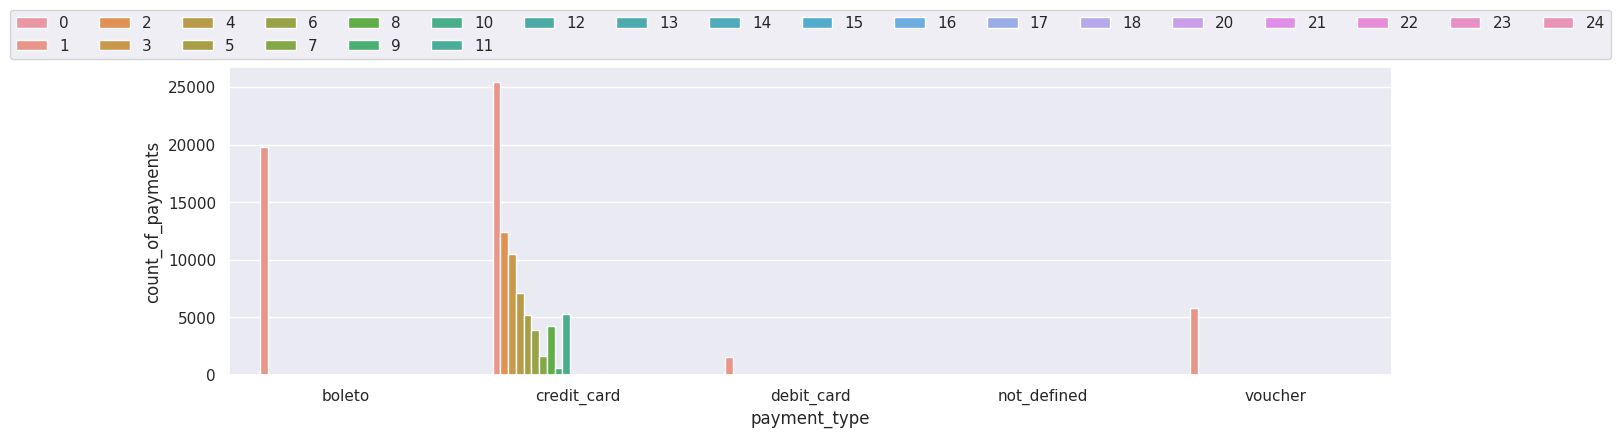

In [ ]:
sns.set(rc={'figure.figsize':(15,4)})
sns.barplot(x='payment_type', y='count_of_payments', hue='payment_installments', data=df); plt.legend(loc='lower center', ncol=18, bbox_to_anchor=(.5, 1))

Only credit card payments can come with installment plans, all other forms of payment, boleto, debit, voucher pay the amount upfront.

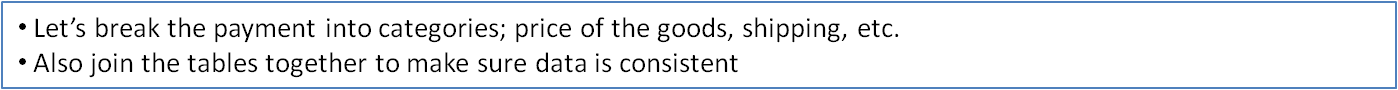

In [ ]:
order_payments[order_payments['order_id'] == 'fffc94f6ce00a00581880bf54a75a037']

order_id  payment_sequential payment_type  \
69123  fffc94f6ce00a00581880bf54a75a037                   1       boleto   

       payment_installments  payment_value  
69123                     1          343.4

In [ ]:
order_items[order_items['order_id'] == 'fffc94f6ce00a00581880bf54a75a037']

order_id  order_item_id  \
112645  fffc94f6ce00a00581880bf54a75a037              1   

                              product_id                         seller_id  \
112645  4aa6014eceb682077f9dc4bffebc05b0  b8bc237ba3788b23da09c0f1f3a3288c   

       shipping_limit_date   price  freight_value  
112645 2018-05-02 04:11:01  299.99          43.41

In [ ]:
# Let's check if payments and price/freight data is consistent for all orders!
# building a new joined dataframe
# base is "orders" table, always 1 row for 1 order. Other tables aggragated to order level before applying the left join.
df0 = orders[['order_id', 'order_status', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date']]
df1 = order_payments[['order_id','payment_value']].groupby('order_id').sum().reset_index()
df2 = order_items[['order_id', 'price','freight_value']].groupby('order_id').sum().reset_index()
df3 = order_payments[['order_id', 'payment_installments']].groupby('order_id').max().reset_index()

joined_df = df0.merge(df1, on='order_id', how='left').merge(df2, on='order_id', how='left').merge(df3, on='order_id', how='left')
joined_df['sum_price_freight'] = joined_df['price'] + joined_df['freight_value']
joined_df['delta_pay_val_vs_sum'] = round(joined_df['payment_value'] - joined_df['sum_price_freight'],1)

In [ ]:
joined_df[['order_id', 'sum_price_freight', 'payment_value']].sample(5)

order_id  sum_price_freight  payment_value
9426   9fcf372852e7c46001a305a781628069              89.17          89.17
63625  4160b6447ad70e6d73f7221dd970bbe9            3076.13        3076.13
52362  170f94ae030b06759974c36f29faf658             219.79         219.79
66712  bba25df31ab586c63517d9d4c8cd1773             253.88         253.88
25420  bdf7cbcf2a174866c15ade0d9a55bf7d             217.58         217.58

In [ ]:
# Are they always identical?
print(f'sum of payment value and freight value equals zero:{sum(joined_df["delta_pay_val_vs_sum"]==0)}  Non zero:{sum(joined_df["delta_pay_val_vs_sum"]!=0)}')

sum of payment value and freight value equals zero:98405  Non zero:1036


<Axes: >

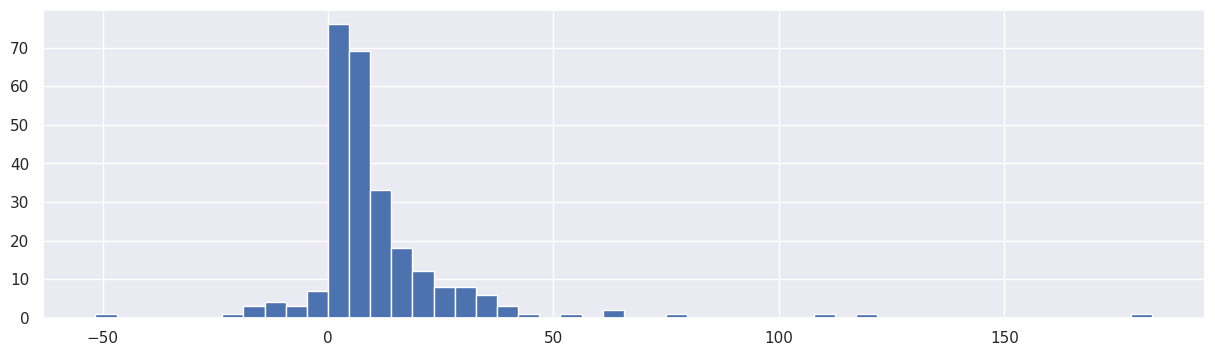

In [ ]:
# let's build the histogram of the delta, where payment sum is different than sum of price + freight of the order
joined_df[joined_df["delta_pay_val_vs_sum"]!=0]["delta_pay_val_vs_sum"].hist(bins=50)

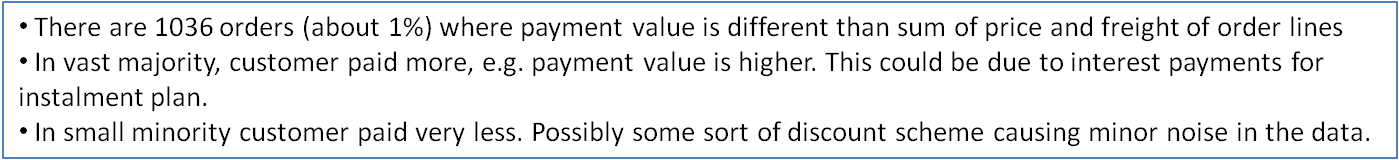

In [ ]:
#interest charge hypothesis rings true, all cases where customer paid more, almost always come instalment plan payments!
joined_df[joined_df["delta_pay_val_vs_sum"]>0][['order_id', 'payment_value', 'sum_price_freight', 'delta_pay_val_vs_sum', 'payment_installments']].iloc[60:66]

order_id  payment_value  sum_price_freight  \
27428  aeffea2c78ec9b15d6cd7478c9072c07         135.22             117.08   
28488  5f20455f0e74de9eae30de410c811013          92.87              83.07   
28642  33a7b8ae888999afb219263e9a36fb77         198.19             175.34   
29365  3c845174981c9b87340aa1ce5ef7fc9e         280.80             253.95   
29413  47bc2fbe3e9b64a723dd530a4f1612b8          74.35              65.78   
30103  38246d20fb91403c9ed13e1aa3c665ad          73.59              69.56   

       delta_pay_val_vs_sum  payment_installments  
27428                  18.1                  12.0  
28488                   9.8                   9.0  
28642                  22.8                  10.0  
29365                  26.9                   8.0  
29413                   8.6                   7.0  
30103                   4.0                   4.0

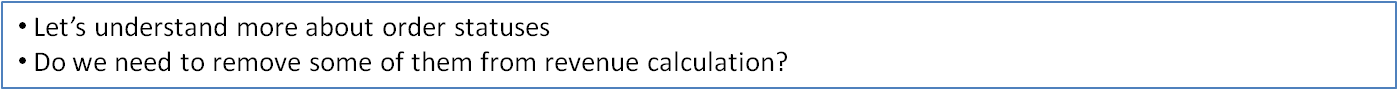

In [ ]:
joined_df['order_status'].value_counts(normalize=False)

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [ ]:
for col in ['canceled', 'unavailable', 'invoiced', 'processing', 'created', 'approved']:
  display(joined_df[joined_df['order_status']==col].sample(3, replace=True))
  print('\n')

order_id order_status order_purchase_timestamp  \
8722   5687ad45d33870c742b2cdacaf758353     canceled      2018-05-21 22:53:49   
90061  765917871914309e5c5f9ed151155ad4     canceled      2018-02-26 11:04:23   
15676  2c8740f9df6d253c15dc035eba80ebed     canceled      2017-04-12 11:23:01   

        order_approved_at order_delivered_carrier_date  \
8722  2018-05-22 02:15:44                          NaT   
90061 2018-02-26 11:40:26                          NaT   
15676 2017-04-12 11:30:25                          NaT   

      order_delivered_customer_date  payment_value   price  freight_value  \
8722                            NaT          69.14   57.99          11.15   
90061                           NaT          62.78   55.00           7.78   
15676                           NaT         187.67  139.99          47.68   

       payment_installments  sum_price_freight  delta_pay_val_vs_sum  
8722                    1.0              69.14                   0.0  
90061                   3.0              62.78                   0.0  
15676                   3.0             187.67                  -0.0

order_id order_status order_purchase_timestamp  \
35138  0010dedd556712d7bb69a19cb7bbd37a  unavailable      2017-10-21 19:32:06   
69934  92fca7ed7b7df4695007bd7f227e3333  unavailable      2017-02-01 12:03:36   
20607  ad9a8214948a5bbd4fa03af2ea598a20  unavailable      2017-05-07 21:27:38   

        order_approved_at order_delivered_carrier_date  \
35138 2017-10-24 03:25:32                          NaT   
69934 2017-02-01 12:15:56                          NaT   
20607 2017-05-07 21:42:10                          NaT   

      order_delivered_customer_date  payment_value  price  freight_value  \
35138                           NaT         111.12    NaN            NaN   
69934                           NaT          52.57    NaN            NaN   
20607                           NaT         340.20    NaN            NaN   

       payment_installments  sum_price_freight  delta_pay_val_vs_sum  
35138                   1.0                NaN                   NaN  
69934                   1.0                NaN                   NaN  
20607                  10.0                NaN                   NaN

order_id order_status order_purchase_timestamp  \
75835  a728ee4ebe3964a5a4ab8b0409eaabc1     invoiced      2018-01-10 21:22:20   
70586  dadbe5c0d37a042483c113e0cbbe2208     invoiced      2017-05-01 10:43:06   
43818  9d8422be45fb68fd2ea1e11898d8fa3d     invoiced      2018-05-02 23:09:48   

        order_approved_at order_delivered_carrier_date  \
75835 2018-01-11 11:36:23                          NaT   
70586 2017-05-01 10:55:16                          NaT   
43818 2018-05-04 03:12:18                          NaT   

      order_delivered_customer_date  payment_value   price  freight_value  \
75835                           NaT         377.17  358.90          18.27   
70586                           NaT         370.72  349.99          20.73   
43818                           NaT         660.41  649.00          11.41   

       payment_installments  sum_price_freight  delta_pay_val_vs_sum  
75835                   1.0             377.17                   0.0  
70586                  10.0             370.72                   0.0  
43818                   1.0             660.41                   0.0

order_id order_status order_purchase_timestamp  \
8106   8fb030b413de395dcbb7cb1a3c9b256e   processing      2017-02-12 00:02:36   
56244  6c98fa39891b33399785aeac3d7ee926   processing      2017-02-28 12:49:50   
33865  f2db192253fbe0e938681e583c8e99e4   processing      2017-09-22 11:05:56   

        order_approved_at order_delivered_carrier_date  \
8106  2017-02-12 00:17:20                          NaT   
56244 2017-02-28 13:01:27                          NaT   
33865 2017-09-22 11:27:36                          NaT   

      order_delivered_customer_date  payment_value  price  freight_value  \
8106                            NaT         214.09  175.9          38.19   
56244                           NaT         424.04  380.0          44.04   
33865                           NaT          57.98   42.0          15.98   

       payment_installments  sum_price_freight  delta_pay_val_vs_sum  
8106                    1.0             214.09                   0.0  
56244                   2.0             424.04                   0.0  
33865                   3.0              57.98                  -0.0

order_id order_status order_purchase_timestamp  \
9238   dba5062fbda3af4fb6c33b1e040ca38f      created      2018-02-09 17:21:04   
55086  35de4050331c6c644cddc86f4f2d0d64      created      2017-12-05 01:07:58   
55086  35de4050331c6c644cddc86f4f2d0d64      created      2017-12-05 01:07:58   

      order_approved_at order_delivered_carrier_date  \
9238                NaT                          NaT   
55086               NaT                          NaT   
55086               NaT                          NaT   

      order_delivered_customer_date  payment_value  price  freight_value  \
9238                            NaT         137.60    NaN            NaN   
55086                           NaT         105.87    NaN            NaN   
55086                           NaT         105.87    NaN            NaN   

       payment_installments  sum_price_freight  delta_pay_val_vs_sum  
9238                    1.0                NaN                   NaN  
55086                   7.0                NaN                   NaN  
55086                   7.0                NaN                   NaN

order_id order_status order_purchase_timestamp  \
44897  a2e4c44360b4a57bdff22f3a4630c173     approved      2017-02-06 20:18:17   
44897  a2e4c44360b4a57bdff22f3a4630c173     approved      2017-02-06 20:18:17   
88457  132f1e724165a07f6362532bfb97486e     approved      2017-04-25 01:25:34   

        order_approved_at order_delivered_carrier_date  \
44897 2017-02-06 20:30:19                          NaT   
44897 2017-02-06 20:30:19                          NaT   
88457 2017-04-30 20:32:41                          NaT   

      order_delivered_customer_date  payment_value  price  freight_value  \
44897                           NaT          61.62   39.7          21.92   
44897                           NaT          61.62   39.7          21.92   
88457                           NaT         179.46  169.9           9.56   

       payment_installments  sum_price_freight  delta_pay_val_vs_sum  
44897                   1.0              61.62                  -0.0  
44897                   1.0              61.62                  -0.0  
88457                   5.0             179.46                   0.0

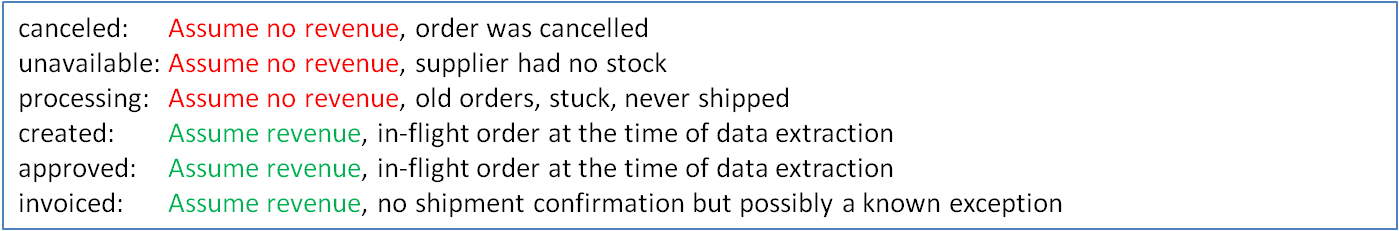

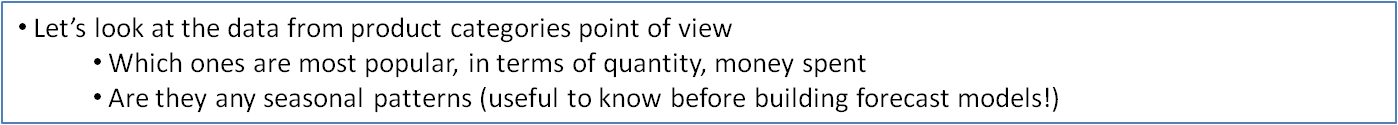

In [ ]:
#join a few tables to bring information together: order date, order status, order items, order items product category, price and freight_value
#1 row corresponds to 1 order item, not 1 order

joined_df_2 = order_items.merge(orders[['order_id', 'order_status', 'order_purchase_timestamp']],
                  on = 'order_id').merge(products.merge(product_categories_english, on = 'product_category_name')
                  [['product_id', 'product_category_name_english']], on='product_id')\
                  [['order_id', 'order_purchase_timestamp', 'order_item_id', 'product_category_name_english', 'price', 'freight_value', 'order_status']]
joined_df_2.columns = ['order_id', 'purchase', 'item_id', 'category', 'price', 'freight', 'order_status']
joined_df_2.head(5)

order_id            purchase  item_id    category  \
0  00010242fe8c5a6d1ba2dd792cb16214 2017-09-13 08:59:02        1  cool_stuff   
1  130898c0987d1801452a8ed92a670612 2017-06-28 11:52:20        1  cool_stuff   
2  532ed5e14e24ae1f0d735b91524b98b9 2018-05-18 10:25:53        1  cool_stuff   
3  6f8c31653edb8c83e1a739408b5ff750 2017-08-01 18:38:42        1  cool_stuff   
4  7d19f4ef4d04461989632411b7e588b9 2017-08-10 21:48:40        1  cool_stuff   

   price  freight order_status  
0   58.9    13.29    delivered  
1   55.9    17.96    delivered  
2   64.9    18.33    delivered  
3   58.9    16.17    delivered  
4   58.9    13.29    delivered

In [ ]:
#let's remove cancelled and invalid orders, also add a log_price column for charting price
joined_df_2 = joined_df_2[~joined_df_2['order_status'].isin(['canceled', 'unavailable', 'processing'])]
joined_df_2['log_price'] = joined_df_2['price'].apply(lambda x: np.log(x) if x >1 else np.NaN)

In [ ]:
joined_df_2['category'].value_counts().sort_index()[:20]

agro_industry_and_commerce           212
air_conditioning                     295
art                                  201
arts_and_craftmanship                 24
audio                                363
auto                                4189
baby                                3032
bed_bath_table                     11089
books_general_interest               543
books_imported                        59
books_technical                      266
cds_dvds_musicals                     14
christmas_supplies                   151
cine_photo                            72
computers                            203
computers_accessories               7764
consoles_games                      1121
construction_tools_construction      921
construction_tools_lights            302
construction_tools_safety            187
Name: category, dtype: int64

There are 71 product categories in total. Some are very popular, others scarce in the data, some newly added, some older names. Cleaning needed.

I manually grouped them into "super categories", reducing the number of groups to 22, each with a meaningful volume

In [ ]:
super_categories = pd.read_csv(r'/content/gdrive/MyDrive/Data_Scientist_Case/super_categories.csv')
super_categories = super_categories[['Raw_Category','Super_Catergory']]; super_categories.set_index('Raw_Category', inplace= True, drop = True)

In [ ]:
joined_df_2['category_2'] = joined_df_2['category'].map(super_categories.to_dict()['Super_Catergory'])
joined_df_2['category_2'].value_counts().sort_index()

auto                      4189
bed_bath_table           11553
children                  7099
computers                 1324
computers_accessories     7764
construction              2227
cool_stuff                3770
electronics               7601
fashion                   2618
food                      1157
furniture_home            9183
garden_tools              4316
health_beauty             9619
home_appliances           2640
housewares                6888
misc                      4178
office_furniture          1685
perfumery                 3390
pet_shop                  1940
sports_leisure            8566
stationery                2500
watches_gifts             5939
Name: category_2, dtype: int64

<Axes: title={'center': 'log_price'}, xlabel='category_2'>

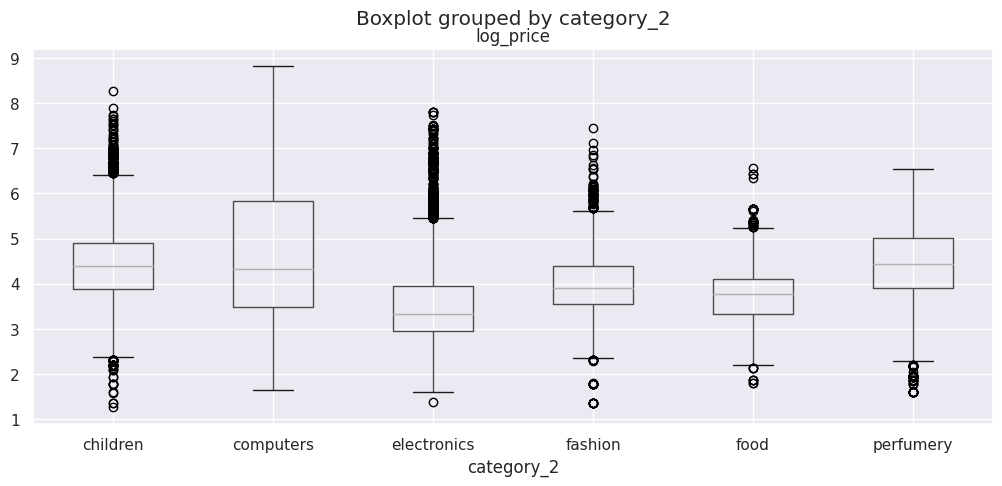

In [ ]:
#Let's take a look if price ranges differ
joined_df_2[joined_df_2['category_2'].isin(['children', 'perfumery', 'electronics', 'fashion', 'computers','food'])].boxplot(column ='log_price', by='category_2',
                                          figsize = (12, 5))

Some product categories more expensive than others, as expected

In [ ]:
# Let's switch to Time-series analysis to spot trends and seasonality!
# Let's build a time series chart for quantity sold and sum of price paid (excluding freight)
# We'll aggregate to week ending level to smoothen the chart, week_ending sunday
joined_df_2['week_ending'] = joined_df_2['purchase'].apply(lambda x: (x - datetime.timedelta(days=x.weekday()) + datetime.timedelta(days=6)).date())

In [ ]:
#function which can read the dataframe and various build charts for different product categories
def build_time_series_charts(df, category_list = ['all'], chart_type = ['Sales Value', 'QTY'], chart_format='default'):
  global aggragated_df; prev_df_to_plot = pd.DataFrame()
  sns.set_style("ticks")
  for c in chart_type:
    if c == 'QTY':
      fig, ax = plt.subplots(figsize=(14, 5)); ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b-%y"))
      aggragated_df_by_cat = df[['category_2', 'week_ending', 'price', ]].groupby(['category_2', 'week_ending']).count().reset_index()
      aggragated_df = df[['week_ending', 'price']].groupby(['week_ending']).count().reset_index()
      weeks_series = aggragated_df[['week_ending']].drop_duplicates()['week_ending']; x_ticks_series = aggragated_df[['week_ending']].drop_duplicates().iloc[::3, :]['week_ending']
      line_collate = []
      if chart_format=='default':
        for i in category_list:
          if i in ['all', 'freight']:
            this_line = plt.bar(weeks_series, aggragated_df['price'], width=5)
          else:
            df_to_plot = aggragated_df[['week_ending']].drop_duplicates()[['week_ending']].merge(aggragated_df_by_cat.query('category_2 == @i'), on='week_ending', how='left')
            if prev_df_to_plot.empty: this_line = plt.bar(weeks_series, df_to_plot['price'], width=5)
            else: this_line = plt.bar(weeks_series, df_to_plot['price'], width=5, bottom=prev_df_to_plot['price'])
            prev_df_to_plot = df_to_plot.copy()
          line_collate.append(this_line)
      if chart_format=='line':
        for i in category_list:
          if i == 'all':
            this_line, = plt.plot(weeks_series, aggragated_df['price'], marker='o', linestyle='--', markersize=3)
          else:
            df_to_plot = aggragated_df[['week_ending']].drop_duplicates()[['week_ending']].merge(aggragated_df_by_cat.query('category_2 == @i'), on='week_ending', how='left')
            this_line, = plt.plot(weeks_series, df_to_plot['price'], marker='o', linestyle='-', markersize=3)
          line_collate.append(this_line)
      plt.legend(line_collate, category_list, loc= 0)
      plt.title(f'Weekly Sales by QTY sold for {category_list}')
      plt.xlabel('Weeks')
      plt.ylabel('QTY sold')
      plt.xticks(x_ticks_series, rotation=45, fontsize=9);
      plt.show()
    if c == 'Sales Value':
      fig, ax = plt.subplots(figsize=(14, 5)); ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b-%y"))
      aggragated_df_by_cat = df[['category_2', 'week_ending', 'price']].groupby(['category_2', 'week_ending']).sum().reset_index()
      aggragated_df = df[['week_ending', 'price', 'freight']].groupby(['week_ending']).sum().reset_index()
      weeks_series = aggragated_df[['week_ending']].drop_duplicates()['week_ending']; x_ticks_series = aggragated_df[['week_ending']].drop_duplicates().iloc[::3, :]['week_ending']
      line_collate = []
      for i in category_list:
        if i == 'all':
          this_line, = plt.plot(weeks_series, aggragated_df['price'], marker='o', linestyle='--', markersize=3)
        elif i == 'freight':
          this_line, = plt.plot(weeks_series, aggragated_df['freight'], marker='o', linestyle='--', markersize=3)
        else:
          df_to_plot = aggragated_df[['week_ending']].drop_duplicates()[['week_ending']].merge(aggragated_df_by_cat.query('category_2 == @i'), on='week_ending', how='left')
          this_line, = plt.plot(weeks_series, df_to_plot['price'], marker='o', linestyle='-', markersize=3)
        line_collate.append(this_line)
      plt.legend(line_collate, category_list, loc= 0)
      plt.title(f'Weekly Sales by Value for {category_list}')
      plt.xlabel('Weeks')
      plt.ylabel('Sales Value R$')
      plt.xticks( x_ticks_series, rotation=45, fontsize=9);
      plt.show()

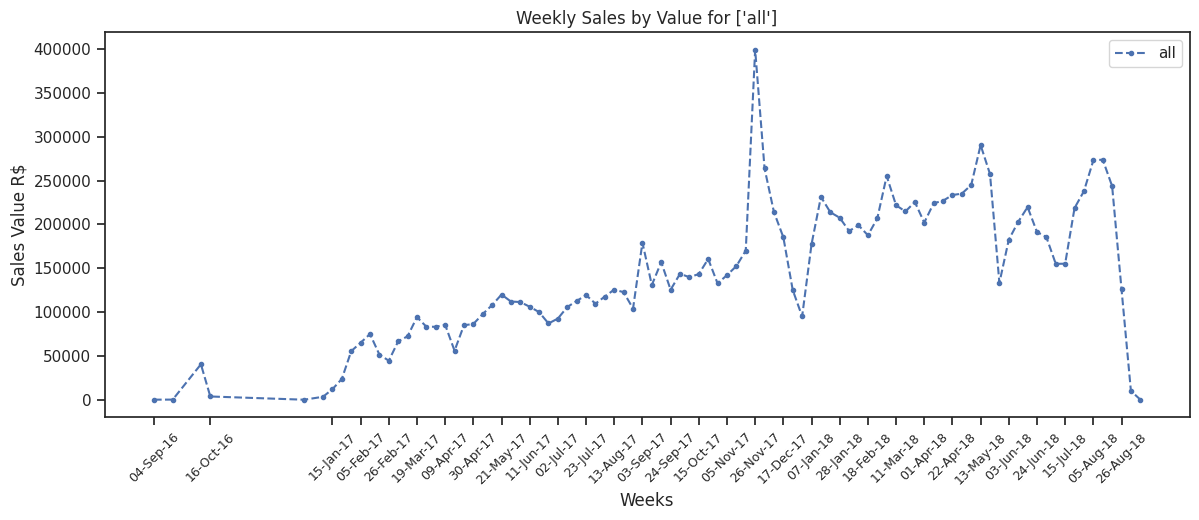

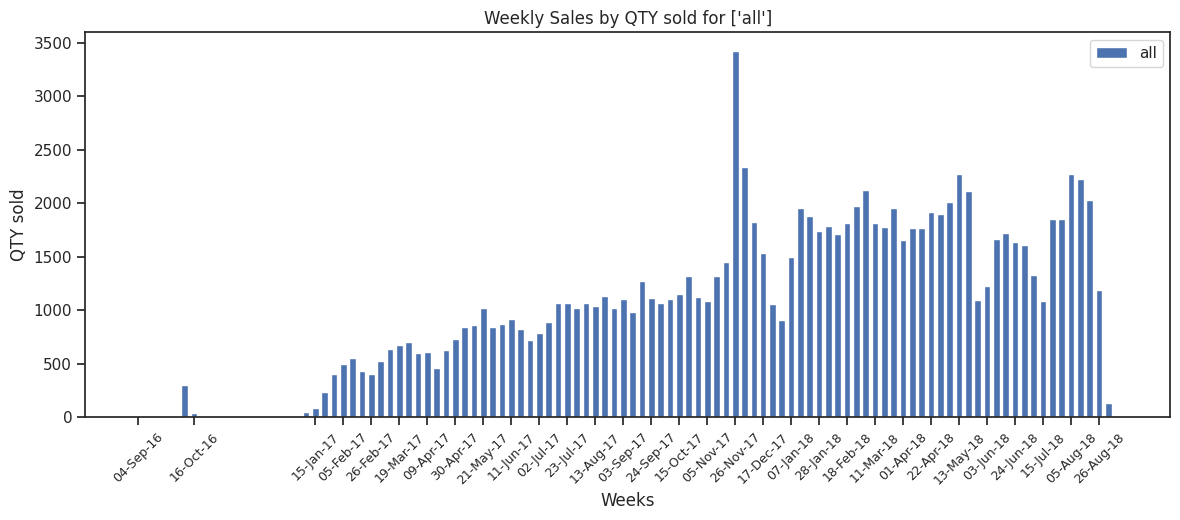

In [ ]:
build_time_series_charts(joined_df_2, category_list = ['all'], chart_type = ['Sales Value', 'QTY'])

There seem to gaps at the beginning and end of dataset. We'll need to trim them from traning data when traning ML model

Zooming into specfic dates reveal the peak is a Black Friday (2017-11-24), which had a surge in volume, and then ramping down of volume in the following days.

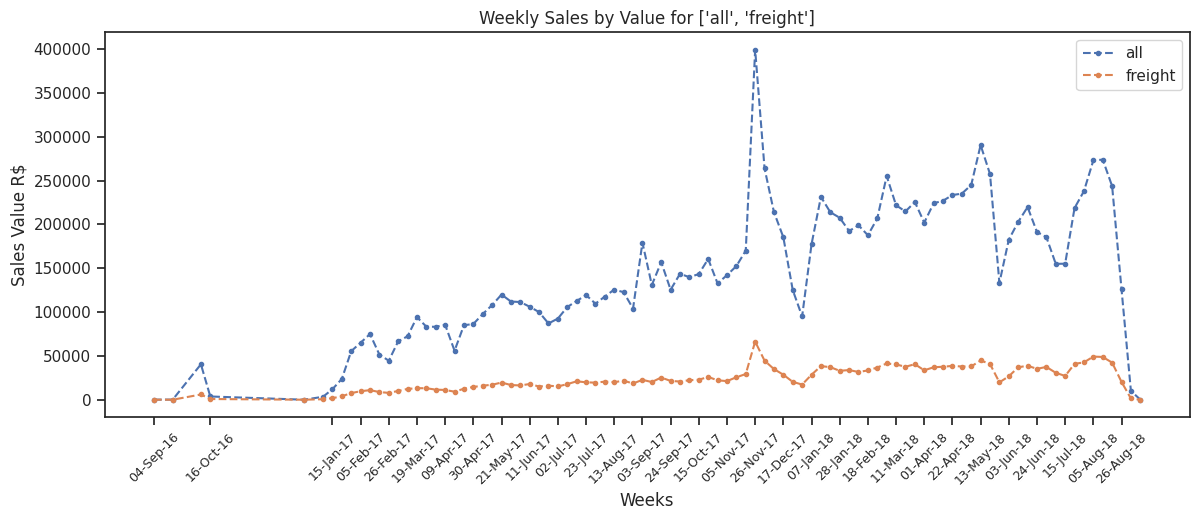

In [ ]:
build_time_series_charts(joined_df_2, category_list = ['all', 'freight'], chart_type = ['Sales Value'])

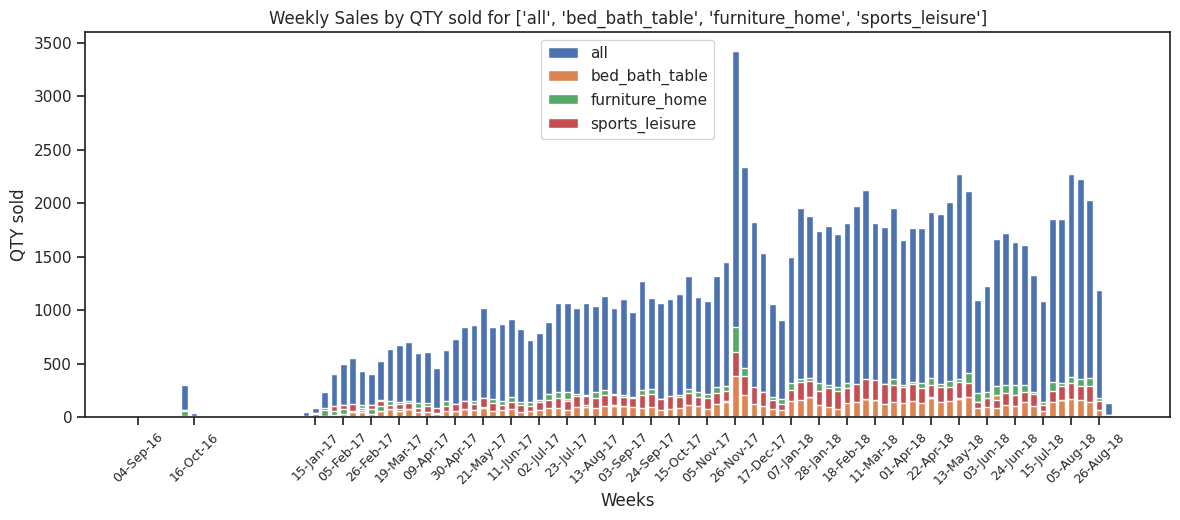

In [ ]:
# Take a look at different product categories
build_time_series_charts(joined_df_2, category_list = ['all','bed_bath_table','furniture_home', 'sports_leisure'], chart_type = ['QTY'])

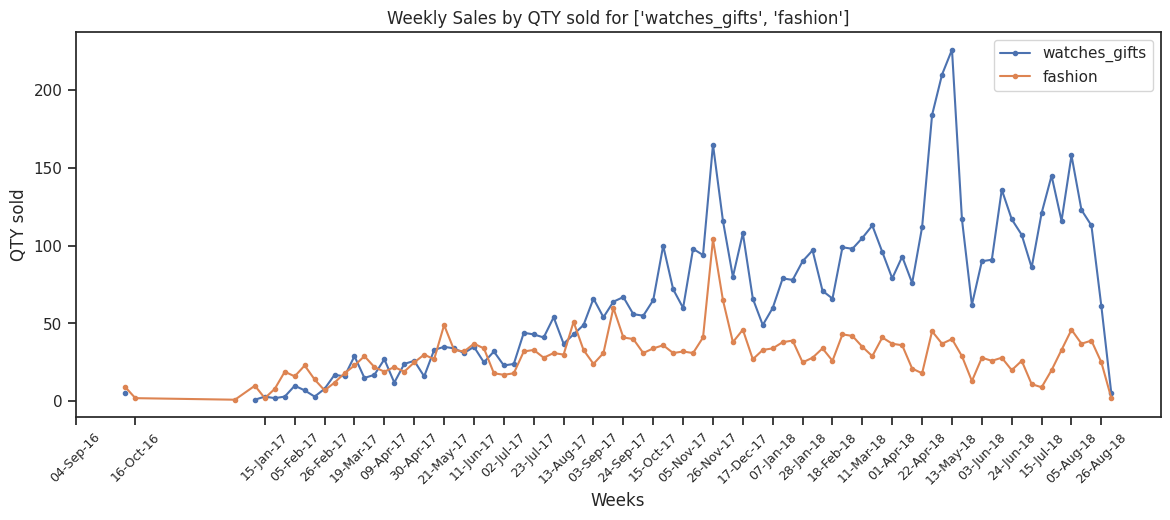

In [ ]:
#some product categories have similar patterns
build_time_series_charts(joined_df_2, category_list = ['watches_gifts','fashion'], chart_type = ['QTY'], chart_format='line')

Similar seasonality but different trend

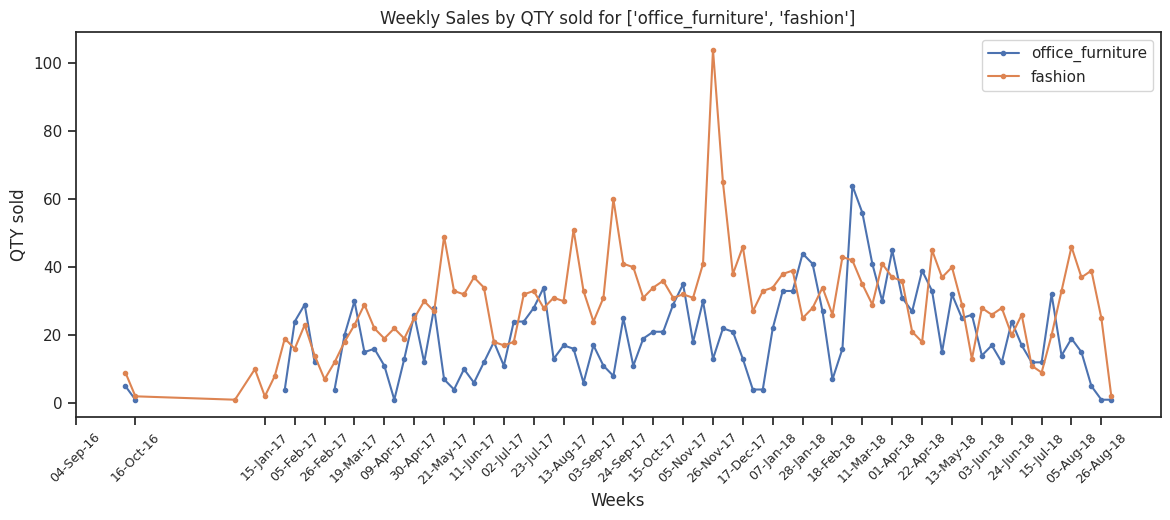

In [ ]:
# other product categories don't have much in common
build_time_series_charts(joined_df_2, category_list = ['office_furniture','fashion'], chart_type = ['QTY'], chart_format='line')

No correlation at all

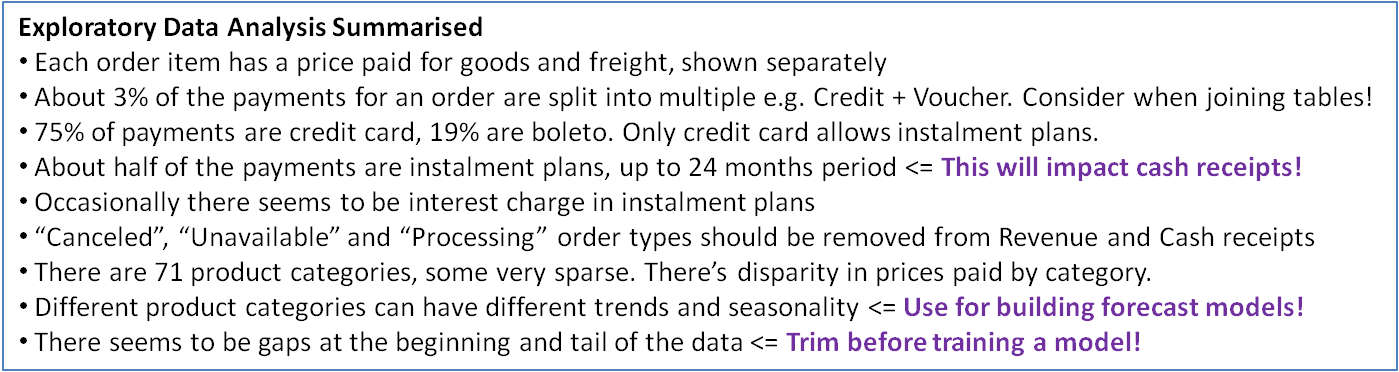

#### ML based Forecast Models

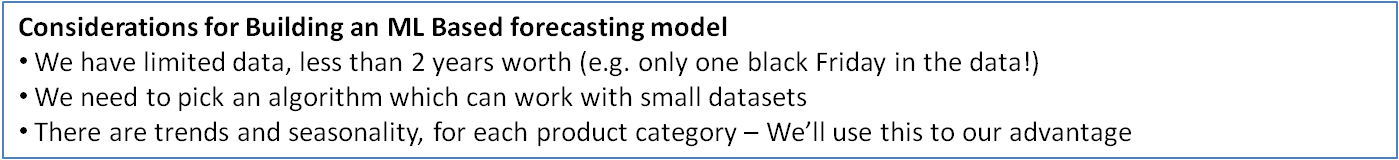

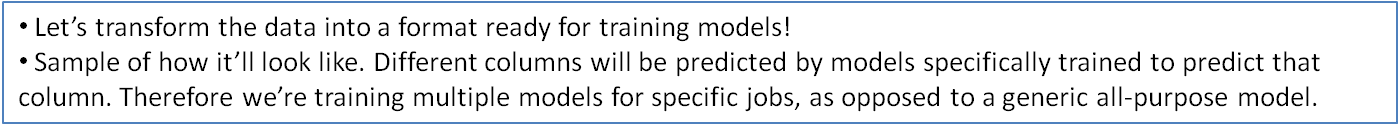

##### Sales Value Forecast Models

In [ ]:
# Should look like this
multi_index = pd.MultiIndex.from_tuples([('Aggragates', 'day_purchased'), ('Aggregates', 'QTY_order_lines'), ('Aggregates', 'all_sales_value'), ('Aggregates', 'total_freight_value'), ('Product_Cat', 'bed_bath_table'), ('Product_Cat', 'furniture_home'),('Product_Cat', 'sports_leisure'),('Product_Cat', 'Misc'),])
data = {('Aggragates', 'day_purchased'): datetime.date(2017, 7, 16), ('Aggregates', 'QTY_order_lines'): [158], ('Aggregates', 'all_sales_value'): [113435.18/7], ('Aggregates', 'total_freight_value'): [21156.4/7], ('Product_Cat', 'bed_bath_table'): [16031.89/7],  ('Product_Cat', 'furniture_home'): [4365.28/7], ('Product_Cat', 'sports_leisure'):[9801.44/7], ('Product_Cat', 'Misc'): [14097.15/7]}
pd.DataFrame(data, columns=multi_index)

Aggragates      Aggregates                                      \
  day_purchased QTY_order_lines all_sales_value total_freight_value   
0    2017-07-16             158    16205.025714         3022.342857   

     Product_Cat                                             
  bed_bath_table furniture_home sports_leisure         Misc  
0        2290.27     623.611429    1400.205714  2013.878571

In [ ]:
#tranform data through; aggregations, joins and pivots
daily_sales_orders = order_items[['order_id', 'product_id', 'price', 'freight_value']]
valid_orders = orders[~orders.order_status.isin([['canceled', 'unavailable', 'processing']])][['order_id', 'order_purchase_timestamp']]
products_cats = products[['product_id', 'product_category_name']].merge(product_categories_english, on='product_category_name'); products_cats['category_2'] = products_cats['product_category_name_english'].map(super_categories.to_dict()['Super_Catergory'])
daily_sales_orders = daily_sales_orders.merge(valid_orders, on='order_id').merge(products_cats[['product_id','category_2']], on='product_id')
daily_sales_orders['day_purchased'] = daily_sales_orders['order_purchase_timestamp'].apply(lambda x: x.date())
daily_sales_orders_agg = daily_sales_orders[['price','category_2','day_purchased']].groupby(['category_2','day_purchased']).sum().reset_index()
daily_sales_orders_freight = daily_sales_orders[['freight_value','day_purchased']].groupby(['day_purchased']).aggregate(['sum','count'])
daily_sales_orders_freight; daily_sales_orders_freight.columns = ['freight_value', 'QTY_items_sold']
daily_sales_orders_agg = daily_sales_orders_agg.pivot(index= 'day_purchased', columns='category_2', values='price').reset_index().merge(daily_sales_orders_freight, left_on='day_purchased', right_on='day_purchased')
daily_sales_orders_agg.fillna(0, inplace=True)
daily_sales_orders_agg = daily_sales_orders_agg[['day_purchased', 'QTY_items_sold', 'freight_value',  'auto', 'bed_bath_table', 'children', 'computers','computers_accessories', 'construction', 'cool_stuff', 'electronics', 'fashion', 'food', 'furniture_home', 'garden_tools', 'health_beauty', 'home_appliances', 'housewares', 'misc', 'office_furniture', 'perfumery', 'pet_shop', 'sports_leisure', 'stationery', 'watches_gifts']]

In [ ]:
daily_sales_orders_agg.iloc[100:110]

day_purchased  QTY_items_sold  freight_value     auto  bed_bath_table  \
100    2017-04-02              75        1430.83  1596.00         1702.97   
101    2017-04-03              82        1545.47   196.91         1082.60   
102    2017-04-04             102        1742.35   562.88         1614.88   
103    2017-04-05             101        1860.65  1199.90         1001.98   
104    2017-04-06             107        2020.57   246.99         1264.85   
105    2017-04-07              93        1692.45   159.99          699.20   
106    2017-04-08              67        1157.63   316.97          263.69   
107    2017-04-09              78        1466.76   362.89          282.90   
108    2017-04-10              93        1700.83  1049.23          743.89   
109    2017-04-11              83        1490.02   396.79          456.69   

     children  computers  computers_accessories  construction  cool_stuff  \
100    729.39       0.00                 248.89          0.00       99.90   
101    183.89       0.00                  55.80         10.91      109.80   
102    176.88     571.80                 412.05          0.00     1077.80   
103   1269.17       0.00                3220.00          0.00     1325.37   
104    613.49     285.90                 931.00          0.00      673.48   
105    668.49    1669.89                1078.41          0.00      199.99   
106    504.69       0.00                  34.90          0.00      778.88   
107    216.66       0.00                 332.84          0.00      323.97   
108    769.67       0.00                1045.50          0.00     1358.27   
109    405.68       0.00                1373.69          0.00     1027.77   

     ...  health_beauty  home_appliances  housewares     misc  \
100  ...         766.87            59.90      129.99   542.55   
101  ...         189.88            49.50      872.39  2047.07   
102  ...         553.60           355.00      701.27   498.70   
103  ...         814.38            32.90      313.27  2267.60   
104  ...         360.98          3523.00      325.11   102.00   
105  ...         552.65             0.00      162.54   632.60   
106  ...         318.79           198.80      212.85   395.57   
107  ...         724.88           244.80       37.90   512.60   
108  ...         829.64           765.78      129.80   439.70   
109  ...         717.32            27.00      338.08   673.59   

     office_furniture  perfumery  pet_shop  sports_leisure  stationery  \
100            679.11     329.90    119.89          330.39       85.00   
101            761.58     956.69      0.00          431.60       19.44   
102            453.97     902.70     59.90          832.05      129.00   
103              0.00    1308.40    279.78         1219.84      129.80   
104            449.97    2060.30    809.90          259.60      258.80   
105            849.99    1635.49    307.48         1196.06        0.00   
106             39.90     582.80     60.90          847.89        0.00   
107              0.00     502.70    156.00         1747.76        0.00   
108              0.00     841.70      0.00          677.48      299.70   
109              0.00     248.80     75.99          773.40       52.90   

     watches_gifts  
100         538.79  
101         255.61  
102         161.89  
103        1813.62  
104        1594.00  
105        1009.00  
106        2113.90  
107         787.01  
108        1375.00  
109           0.00  

[10 rows x 25 columns]

In [ ]:
#trim the first and last 2 weeks, anomalies identified before, looking at day volume
#trim from 2018-08-23
daily_sales_trimmed = daily_sales_orders_agg.iloc[25:608]; daily_sales_trimmed.reset_index(inplace=True, drop=True)

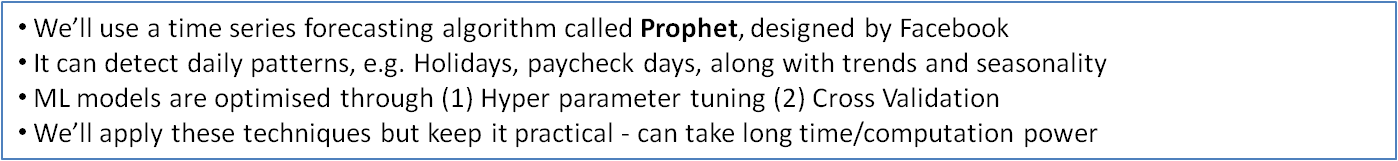

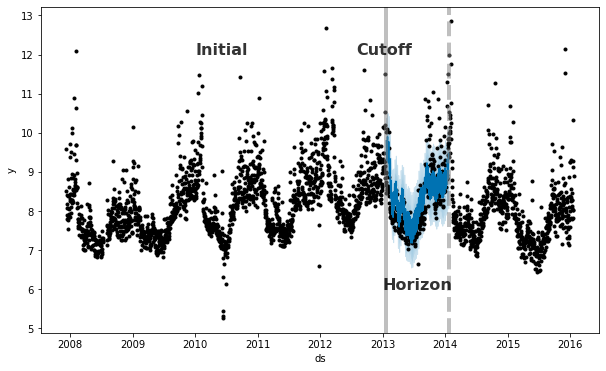

In [ ]:
#function trains a model for a given time series, applies cross validation (3 fold) and hyperparameter tunning, picks the best performing model, saves to cloud
def train_prophet_algoritm(df, save_model=True, save_dir = '/content/gdrive/MyDrive/Data_Scientist_Case/this_model.json', cutoffs_list = ['2018-08-01','2018-07-11','2018-06-20']):

  cutoffs = pd.to_datetime(cutoffs_list)
  param_grid = {
      'changepoint_prior_scale': [0.001, 0.1, 0.5], #[0.001, 0.01, 0.1, 0.5]
      'seasonality_prior_scale': [0.1, 1, 10], #[0.01, 0.1, 1.0, 10.0]
      'holidays_prior_scale':[0.1, 1, 10], # [0.01, 0.1, 1.0, 10.0],
      'seasonality_mode': ['additive', 'multiplicative'],
      'yearly_seasonality': [True],
      'weekly_seasonality': [True],
  }

  all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
  rmses = []

  for params in all_params:
      m = Prophet(**params).fit(df)  # Fit model with given params
      df_cv = cross_validation(m, initial = '10000 days', cutoffs=cutoffs, horizon='21 days')
      df_p = performance_metrics(df_cv, rolling_window=1)
      rmses.append(df_p['rmse'].values[0])

  # Find the best parameters
  tuning_results = pd.DataFrame(all_params)
  tuning_results['rmse'] = rmses
  best_params = all_params[np.argmin(rmses)]
  print(best_params)

  final_model = Prophet(**best_params).fit(df)

  with open(save_dir, 'w') as fout:
    fout.write(model_to_json(final_model))  # Save model
  return final_model

#uses trained model to predict and plot future results
def plot_model_results(model, df, predict_days_ahead = 24, plot_days= 180, return_df = False):
  future = model.make_future_dataframe(periods=predict_days_ahead, freq='1 D', include_history=False)
  forecast = model.predict(future)
  plot_df = pd.concat([df.set_index('ds'), forecast[['ds','yhat_lower','yhat_upper', 'yhat']].set_index('ds')])
  plot_df = plot_df.iloc[-plot_days:]
  fig, ax = plt.subplots(figsize=(14, 5)); ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b-%y"))

  plt.plot(plot_df.index, plot_df['y'], label='y', linestyle='-', marker='o', markersize=4)
  plt.plot(plot_df.index, plot_df['yhat'], label='yhat', linestyle='-', marker='o', markersize=4)
  plt.plot(plot_df.index, plot_df['yhat_lower'], label='yhat_lower', linestyle='dotted', color = 'grey')
  plt.plot(plot_df.index, plot_df['yhat_upper'], label='yhat_upper', linestyle='dotted', color = 'grey')

  x_ticks_series = pd.DataFrame(plot_df.index).iloc[::5, :]['ds']
  plt.xticks(x_ticks_series, rotation=45, fontsize=9);

  plt.xlabel('Date')
  #plt.ylabel('Value')
  plt.legend()

  plt.show()

  if return_df: return plot_df

def load_trained_model(column_name):
  with open(f'/content/gdrive/MyDrive/Data_Scientist_Case/model_{column_name}.json', 'r') as fin:
    m = model_from_json(fin.read())  # Load model
  return m

In [ ]:
# this command will train a new model and save to disk for a given column
if True == True:
  training_data = daily_sales_trimmed[['day_purchased', 'QTY_items_sold']]; training_data.columns=['ds', 'y']
  model_final = train_prophet_algoritm(training_data, save_model=False)

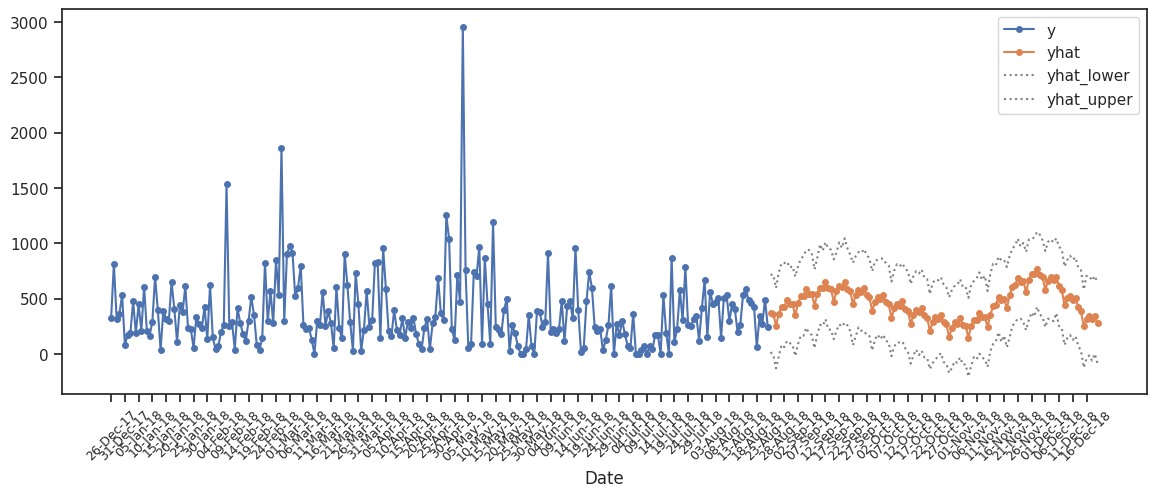

In [ ]:
# we can load a saved model and forecast for any column
model_final = load_trained_model('fashion')
training_data = daily_sales_trimmed[['day_purchased','fashion']]; training_data.columns=['ds', 'y']
plot_model_results(model_final, training_data, predict_days_ahead = 120, plot_days= 360)

In [ ]:
'''
#PowerBI Export
# we can load a saved model and forecast for any column
collated_df = pd.DataFrame()

for i in ['auto', 'bed_bath_table', 'children', 'computers', 'computers_accessories','construction', 'cool_stuff', 'electronics', 'fashion', 'food',
            'furniture_home', 'garden_tools', 'health_beauty', 'home_appliances', 'housewares', 'misc', 'office_furniture', 'perfumery', 'pet_shop', 'sports_leisure', 'stationery', 'watches_gifts']:
  model_final = load_trained_model(i)
  training_data = daily_sales_trimmed[['day_purchased',i]]; training_data.columns=['ds', 'y']
  df = plot_model_results(model_final, training_data, predict_days_ahead = 120, plot_days= 900, return_df = True)
  df['Category'] = i
  if collated_df.empty: collated_df = df
  else: collated_df = pd.concat([collated_df, df], axis=0)

collated_df.index = pd.to_datetime(collated_df.index); collated_df.columns = ['Actual R$', 'Predicted R$', 'Lower Band', 'Upper Band', 'Category']
collated_df.to_csv(r'/content/gdrive/MyDrive/Data_Scientist_Case/category_forecasts.csv')
'''

"\n#PowerBI Export\n# we can load a saved model and forecast for any column\ncollated_df = pd.DataFrame()\n\nfor i in ['auto', 'bed_bath_table', 'children', 'computers', 'computers_accessories','construction', 'cool_stuff', 'electronics', 'fashion', 'food',\n            'furniture_home', 'garden_tools', 'health_beauty', 'home_appliances', 'housewares', 'misc', 'office_furniture', 'perfumery', 'pet_shop', 'sports_leisure', 'stationery', 'watches_gifts']:\n  model_final = load_trained_model(i)\n  training_data = daily_sales_trimmed[['day_purchased',i]]; training_data.columns=['ds', 'y']\n  df = plot_model_results(model_final, training_data, predict_days_ahead = 120, plot_days= 900, return_df = True)\n  df['Category'] = i\n  if collated_df.empty: collated_df = df\n  else: collated_df = pd.concat([collated_df, df], axis=0)\n\ncollated_df.index = pd.to_datetime(collated_df.index); collated_df.columns = ['Actual R$', 'Predicted R$', 'Lower Band', 'Upper Band', 'Category']\ncollated_df.to_csv

In [ ]:
#takes over 1 hour to train all models for all columns
%%time
if True == False:
  for i in ['QTY_items_sold', 'freight_value', 'auto', 'bed_bath_table', 'children', 'computers', 'computers_accessories','construction', 'cool_stuff', 'electronics', 'fashion', 'food',
        'furniture_home', 'garden_tools', 'health_beauty', 'home_appliances', 'housewares', 'misc', 'office_furniture', 'perfumery', 'pet_shop', 'sports_leisure', 'stationery', 'watches_gifts']:

        training_data = daily_sales_trimmed[['day_purchased', i]]; training_data.columns=['ds', 'y']
        model_final = train_prophet_algoritm(training_data, save_dir=f'/content/gdrive/MyDrive/Data_Scientist_Case/model_{i}.json')

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 9.06 µs


In [ ]:
# Plot hollistic forecast, incorporating the sum of all forecasts from product categories.
def predict_from_saved_model_and_plot(daily_sales_trimmed, predict_days_ahead = 24, plot_days= 180, column = 'sales_value'):
  collated_df = pd.DataFrame()

  if column == 'sales_value':
    for i in ['QTY_items_sold', 'freight_value', 'auto', 'bed_bath_table', 'children', 'computers', 'computers_accessories','construction', 'cool_stuff', 'electronics', 'fashion', 'food',
            'furniture_home', 'garden_tools', 'health_beauty', 'home_appliances', 'housewares', 'misc', 'office_furniture', 'perfumery', 'pet_shop', 'sports_leisure', 'stationery', 'watches_gifts']:

      model_final = load_trained_model(i)
      future = model_final.make_future_dataframe(periods=predict_days_ahead, freq='1 D', include_history=False)
      forecast = model_final.predict(future)
      forecast = forecast[['ds', 'yhat']]; forecast.columns = ['ds', i]; forecast.set_index('ds', drop=True, inplace=True)
      if collated_df.empty:
        collated_df = forecast.copy()
      else:
        collated_df = collated_df.merge(forecast, left_index=True, right_index=True)

    collated_df['value_type'] = 'prediction'
    collated_df.reset_index(inplace=True)
    collated_df.rename({'ds':'day_purchased'}, axis=1, inplace=True)
    collated_all = daily_sales_trimmed.copy(); collated_all['value_type'] = 'actual'
    collated_all = pd.concat([collated_all, collated_df],axis=0); collated_all.reset_index(inplace=True, drop=True)
    collated_all['forecast'] = collated_all[['auto', 'bed_bath_table', 'children', 'computers', 'computers_accessories','construction', 'cool_stuff', 'electronics', 'fashion', 'food',
              'furniture_home', 'garden_tools', 'health_beauty', 'home_appliances', 'housewares', 'misc', 'office_furniture', 'perfumery', 'pet_shop', 'sports_leisure', 'stationery', 'watches_gifts']].sum(axis=1)
    collated_all['actual_sales_value'] = collated_all.apply(lambda x: x['forecast'] if x['value_type'] == 'actual' else np.NaN, axis=1)
    collated_all['forecast_sales_value'] = collated_all.apply(lambda x: x['forecast'] if x['value_type'] == 'prediction' else np.NaN, axis=1)

    collated_all = collated_all[-plot_days:]
    fig, ax = plt.subplots(figsize=(14, 5)); ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%b-%y"))

    plt.plot(collated_all.day_purchased, collated_all['actual_sales_value'], label='actual_sales_value', linestyle='-', marker='o', markersize=4)
    plt.plot(collated_all.day_purchased, collated_all['forecast_sales_value'], label='forecast_sales_value', linestyle='-', marker='o', markersize=4)

    x_ticks_series = collated_all[['day_purchased']].iloc[::5, :]['day_purchased'].values
    plt.xticks(x_ticks_series, rotation=45, fontsize=9);

    plt.xlabel('Day')
    plt.ylabel('sales_value in R$')
    plt.legend()
    plt.show()
    return collated_all

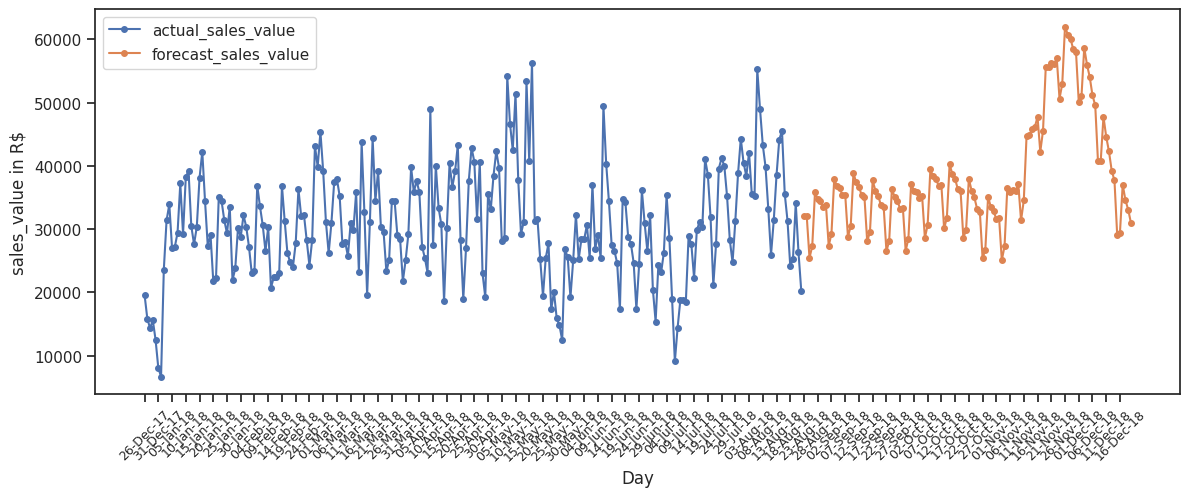

In [ ]:
# predict all sales value, as a summation of values of each product category e.g. 'auto', 'bed_bath_table', 'children', 'computers', 'computers_accessories'
df = predict_from_saved_model_and_plot(daily_sales_trimmed, predict_days_ahead = 120, plot_days= 360)

#Save for Power BI!
#df['day_purchased'] = pd.to_datetime(df['day_purchased'])
#df.to_csv(r'/content/gdrive/MyDrive/Data_Scientist_Case/sales_actuals_forecasts.csv')

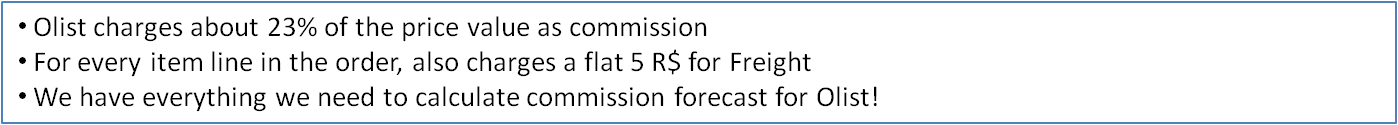

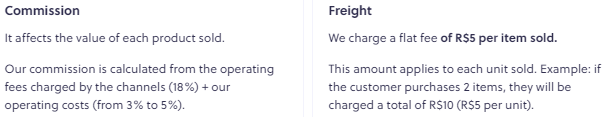

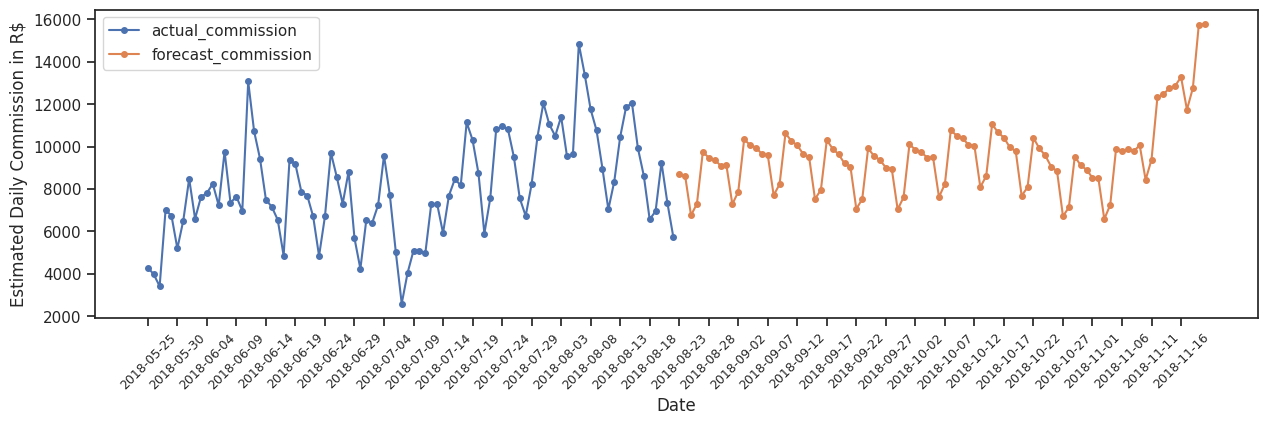

In [ ]:
df = df.iloc[-180:] #show x days only

actuals = df.apply(lambda x: x['QTY_items_sold']*5 + x['actual_sales_value']*0.23 if x['value_type'] == 'actual' else np.NaN, axis=1)
prediction = df.apply(lambda x: x['QTY_items_sold']*5 + x['forecast_sales_value']*0.23 if x['value_type'] == 'prediction' else np.NaN, axis=1)
plt.plot(df.day_purchased, actuals, label='actual_commission', linestyle='-', marker='o', markersize=4)
plt.plot(df.day_purchased, prediction, label='forecast_commission', linestyle='-', marker='o', markersize=4)
x_ticks_series = df[['day_purchased']].iloc[::5, :]['day_purchased'].values
plt.xticks(x_ticks_series, rotation=45, fontsize=9);
plt.xlabel('Date'); plt.ylabel('Estimated Daily Commission in R$'); plt.legend(); plt.show()

##### Cash Receipts Forecast Model

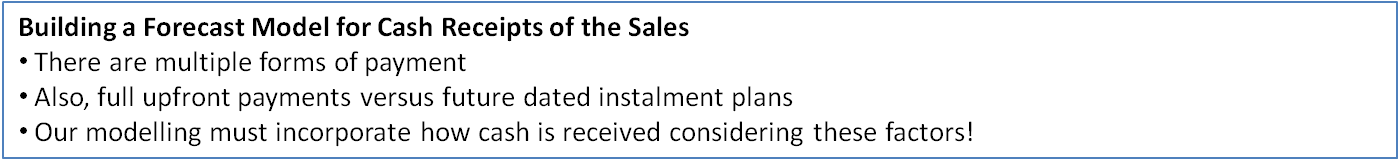

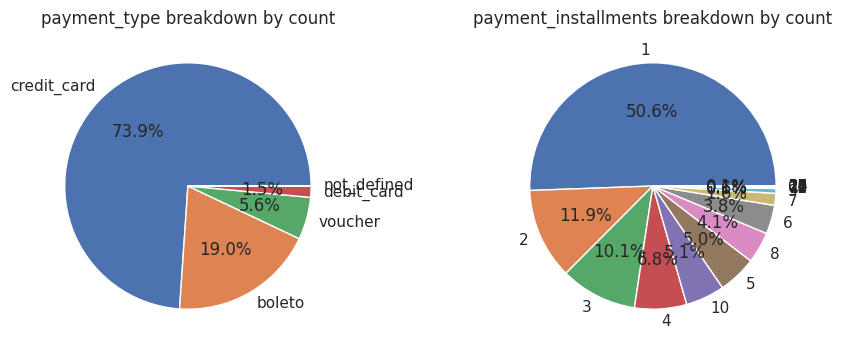

In [ ]:
# Let's remember payment types and installments
fig, axs = plt.subplots(1, 2, figsize=(11, 4))
series = order_payments['payment_type'].value_counts(normalize=True)
axs[0].pie(series,labels = series.index, autopct=autopct_format(series)); axs[0].set_title('payment_type breakdown by count');
series = order_payments['payment_installments'].value_counts(normalize=True)
axs[1].pie(series,labels = series.index, autopct=autopct_format(series)); axs[1].set_title('payment_installments breakdown by count');

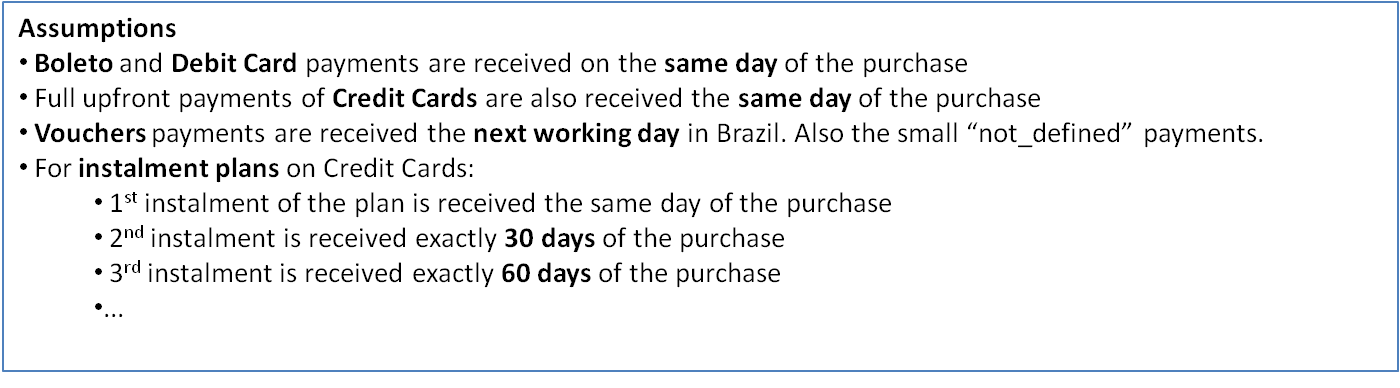

Let's explore how cash flows based on the assumptions

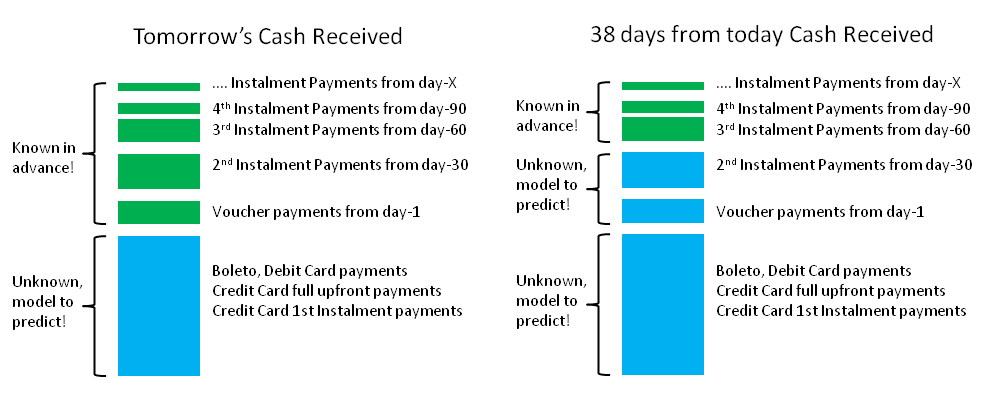

In [ ]:
# let's take a look at payment data. Remember 1 row is 1 payment, and order can be split into multiple payments
# trim data the same way, remove invalid orders the same way
payment_lines_df = order_payments.merge(orders[orders['order_purchase_timestamp'] <= datetime.datetime(2018,8,23)][~orders['order_status'].isin(['canceled', 'unavailable', 'processing'])][['order_id','order_purchase_timestamp']], on='order_id'); payment_lines_df.reset_index(inplace=True, drop=True)
payment_lines_df.iloc[1011:1013]

order_id  payment_sequential payment_type  \
1011  363524b17966c3a64696d5a68c5f4d34                   1  credit_card   
1012  55eda25190659fb615a61fbbaa14013c                   1  credit_card   

      payment_installments  payment_value order_purchase_timestamp  
1011                     4         276.11      2018-05-10 22:19:03  
1012                     3         149.16      2018-05-16 16:44:38

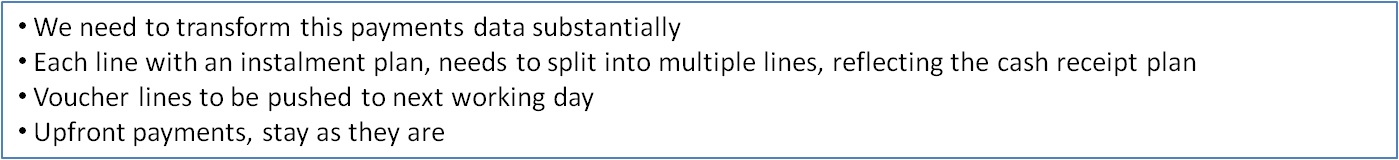

In [ ]:
# takes 15 seconds to run
order_id_collate, purchase_date_collate, payment_sequential_collate, payment_type_collate, payment_installments_collate, payment_value_collate, order_purchase_collate, installment_no_collate = [], [], [], [], [], [], [], []
cal = Brazil()
for index, row in payment_lines_df.iterrows():
  if row['payment_installments'] > 1:
    value_of_installment = round(row['payment_value'] / row['payment_installments'],2)
    for i in range(0, row['payment_installments']):
      order_id_collate.append(row['order_id'])
      payment_sequential_collate.append(row['payment_sequential'])
      payment_type_collate.append(row['payment_type'])
      payment_installments_collate.append(row['payment_installments'])
      payment_value_collate.append(value_of_installment)
      order_purchase_collate.append(row['order_purchase_timestamp'].date() + datetime.timedelta(days=30*(i)))
      installment_no_collate.append(i+1)
      purchase_date_collate.append(row['order_purchase_timestamp'].date())
  elif row['payment_type'] in ['voucher', 'not_defined'] :
      order_id_collate.append(row['order_id'])
      payment_sequential_collate.append(row['payment_sequential'])
      payment_type_collate.append(row['payment_type'])
      payment_installments_collate.append(row['payment_installments'])
      payment_value_collate.append(row['payment_value'])
      order_purchase_collate.append(cal.add_working_days(row['order_purchase_timestamp'], 1))
      installment_no_collate.append(1)
      purchase_date_collate.append(row['order_purchase_timestamp'].date())
  else:
      order_id_collate.append(row['order_id'])
      payment_sequential_collate.append(row['payment_sequential'])
      payment_type_collate.append(row['payment_type'])
      payment_installments_collate.append(row['payment_installments'])
      payment_value_collate.append(row['payment_value'])
      order_purchase_collate.append(row['order_purchase_timestamp'].date())
      installment_no_collate.append(1)
      purchase_date_collate.append(row['order_purchase_timestamp'].date())

In [ ]:
# each cash receipt is one line in this dataframe
payment_plan_df = pd.DataFrame({'order_id': order_id_collate, 'purchase_date': purchase_date_collate,  'cash_receipt': order_purchase_collate, 'payment_sequential': payment_sequential_collate,
'payment_type': payment_type_collate, 'payment_installments': payment_installments_collate, 'installment_no': installment_no_collate, 'payment_value': payment_value_collate})
payment_plan_df['purchase_date'] = pd.to_datetime(payment_plan_df['purchase_date']); payment_plan_df['cash_receipt'] = pd.to_datetime(payment_plan_df['cash_receipt'])

In [ ]:
display(payment_plan_df[payment_plan_df['order_id'] == '363524b17966c3a64696d5a68c5f4d34'])
display(payment_plan_df[payment_plan_df['order_id'] == '55eda25190659fb615a61fbbaa14013c'])

order_id purchase_date cash_receipt  \
2714  363524b17966c3a64696d5a68c5f4d34    2018-05-10   2018-05-10   
2715  363524b17966c3a64696d5a68c5f4d34    2018-05-10   2018-06-09   
2716  363524b17966c3a64696d5a68c5f4d34    2018-05-10   2018-07-09   
2717  363524b17966c3a64696d5a68c5f4d34    2018-05-10   2018-08-08   

      payment_sequential payment_type  payment_installments  installment_no  \
2714                   1  credit_card                     4               1   
2715                   1  credit_card                     4               2   
2716                   1  credit_card                     4               3   
2717                   1  credit_card                     4               4   

      payment_value  
2714          69.03  
2715          69.03  
2716          69.03  
2717          69.03

order_id purchase_date cash_receipt  \
2718  55eda25190659fb615a61fbbaa14013c    2018-05-16   2018-05-16   
2719  55eda25190659fb615a61fbbaa14013c    2018-05-16   2018-06-15   
2720  55eda25190659fb615a61fbbaa14013c    2018-05-16   2018-07-15   

      payment_sequential payment_type  payment_installments  installment_no  \
2718                   1  credit_card                     3               1   
2719                   1  credit_card                     3               2   
2720                   1  credit_card                     3               3   

      payment_value  
2718          49.72  
2719          49.72  
2720          49.72

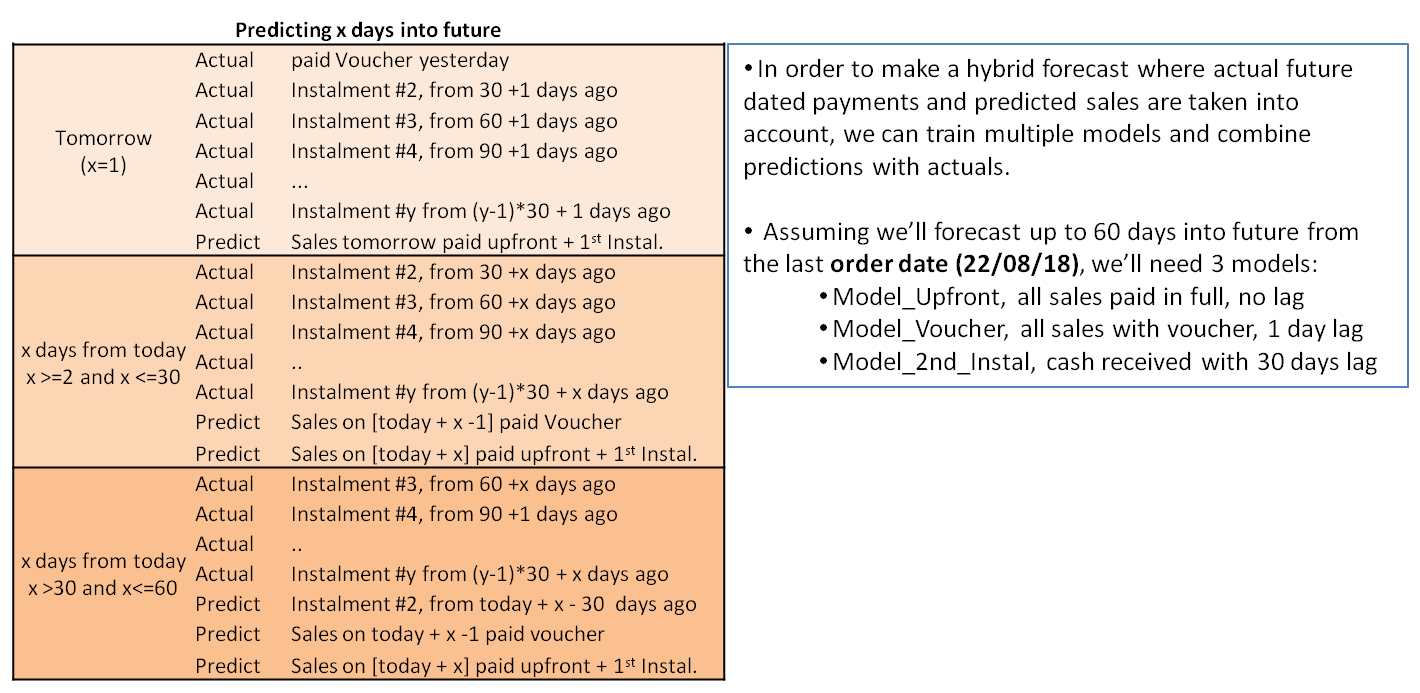

In [ ]:
# Getting the data ready to train 3 models
voucher_df = payment_plan_df[payment_plan_df['payment_type'] == 'voucher'][['cash_receipt', 'payment_value']].groupby('cash_receipt').sum().reset_index(); voucher_df.columns = ['cash_receipt', 'voucher_value']
upfront_df = payment_plan_df.query('installment_no==1 and payment_type!= "voucher"')[['cash_receipt', 'payment_value']].groupby('cash_receipt').sum().reset_index(); upfront_df.columns = ['cash_receipt', 'upfront_value']
second_install_df = payment_plan_df.query('installment_no==2 and payment_type== "credit_card"')[['cash_receipt', 'payment_value']].groupby('cash_receipt').sum().reset_index(); second_install_df.columns = ['cash_receipt', '2nd_instal_value']
display(voucher_df.iloc[-2:]); display(upfront_df.iloc[-2:]); display(second_install_df.iloc[-2:])

cash_receipt  voucher_value
408   2018-08-22         186.65
409   2018-08-23          33.23

cash_receipt  upfront_value
603   2018-08-21       17230.01
604   2018-08-22       13930.07

cash_receipt  2nd_instal_value
599   2018-09-20           4894.09
600   2018-09-21           3619.52

In [ ]:
# Trains a model
training_data = upfront_df.copy(); training_data.columns=['ds', 'y']
if True == False:
  model_final = train_prophet_algoritm(training_data, save_model=False)

#load a model
model_final = load_trained_model('upfront')

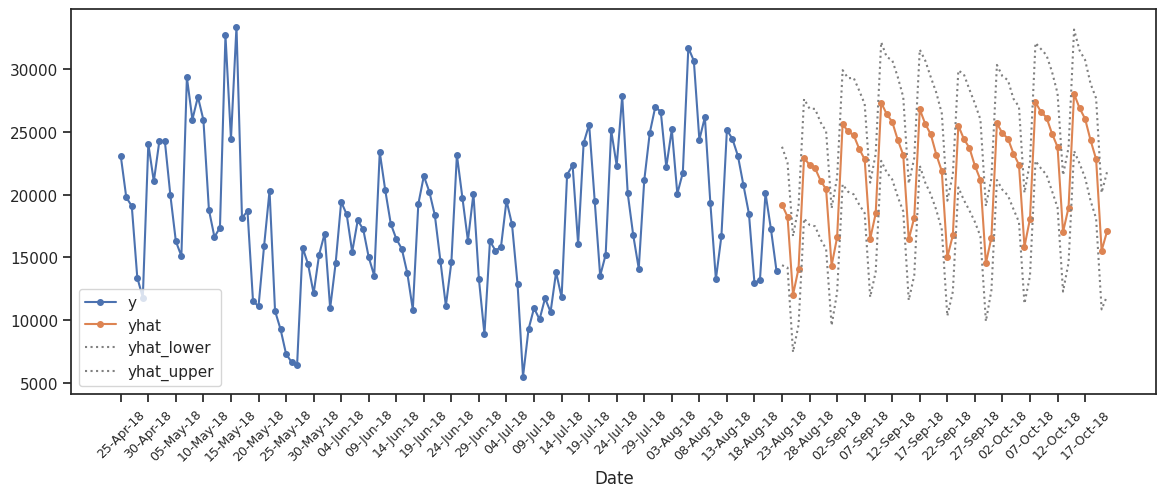

In [ ]:
# Example forecast for Payments Received in Sales paid Upfront
df = plot_model_results(model_final, training_data, predict_days_ahead = 60, plot_days= 180, return_df = True)

In [ ]:
#loop to train 3 models #takes about 5 minutes
names_dict = ['upfront', 'voucher', 'second_instal']; counter = 0
if True == False:
  for i in [upfront_df, voucher_df, second_install_df]:
      training_data = i.copy(); training_data.columns=['ds', 'y']
      model_final = train_prophet_algoritm(training_data, save_dir=f'/content/gdrive/MyDrive/Data_Scientist_Case/model_{names_dict[counter]}.json')
      counter += 1

In [ ]:
# Let's collate the results, where we bring actuals and predictions together
collate_df = pd.DataFrame()
for i in ['upfront', 'voucher', 'second_instal']:
  model_final = load_trained_model(i)
  future = model_final.make_future_dataframe(periods=60, freq='1 D', include_history=False)
  forecast = model_final.predict(future)
  this_forecast = forecast[['ds','yhat']].copy(); this_forecast.columns= ['ds', f'{i}_prediction']; this_forecast.set_index('ds',inplace=True); this_forecast.index.name = ''
  if collate_df.empty: collate_df = this_forecast.copy()
  else: collate_df = pd.concat([collate_df, this_forecast],axis=1)

collate_df.index.name = 'cash_receipt'; collate_df.reset_index(inplace=True)
future_dated_df = payment_plan_df.query('installment_no>=3 and payment_type== "credit_card"')[['cash_receipt', 'payment_value']].groupby('cash_receipt').sum().reset_index(); future_dated_df.columns = ['cash_receipt', 'future_dated_instal']
actuals_forecast_df = upfront_df.merge(voucher_df, how='outer', on='cash_receipt').merge(second_install_df, how='outer', on='cash_receipt').merge(future_dated_df, how='outer', on='cash_receipt').merge(collate_df, how='outer', on='cash_receipt')
actuals_forecast_df.sort_values('cash_receipt', inplace=True)

In [ ]:
#We now have a dataframe where actuals and forecasts are brought together
actuals_forecast_df['actual']= actuals_forecast_df[['upfront_value', 'voucher_value', '2nd_instal_value', 'future_dated_instal']].sum(axis=1)
actuals_forecast_df['predicted']= actuals_forecast_df[['upfront_prediction', 'voucher_prediction', 'voucher_prediction']].sum(axis=1)
actuals_forecast_df.iloc[624:628]

cash_receipt  upfront_value  voucher_value  2nd_instal_value  \
603   2018-08-21       17230.01         388.39           5054.31   
604   2018-08-22       13930.07         186.65           7090.16   
606   2018-08-23            NaN          33.23           6624.78   
615   2018-08-24            NaN            NaN           6145.19   

     future_dated_instal  upfront_prediction  voucher_prediction  \
603             11925.39                 NaN                 NaN   
604             10787.00                 NaN                 NaN   
606             11462.60        19197.119945                 NaN   
615             12322.01        18247.986801          660.227067   

     second_instal_prediction    actual     predicted  
603                       NaN  34598.10      0.000000  
604                       NaN  31993.88      0.000000  
606                       NaN  18120.61  19197.119945  
615                       NaN  18467.20  19568.440935

In [ ]:
#Power BI Extracts
#export_df = actuals_forecast_df[['cash_receipt', 'actual','predicted']].copy(); export_df.set_index('cash_receipt', inplace=True)
#export_df.to_csv('/content/gdrive/MyDrive/Data_Scientist_Case/cash_receipts.csv')

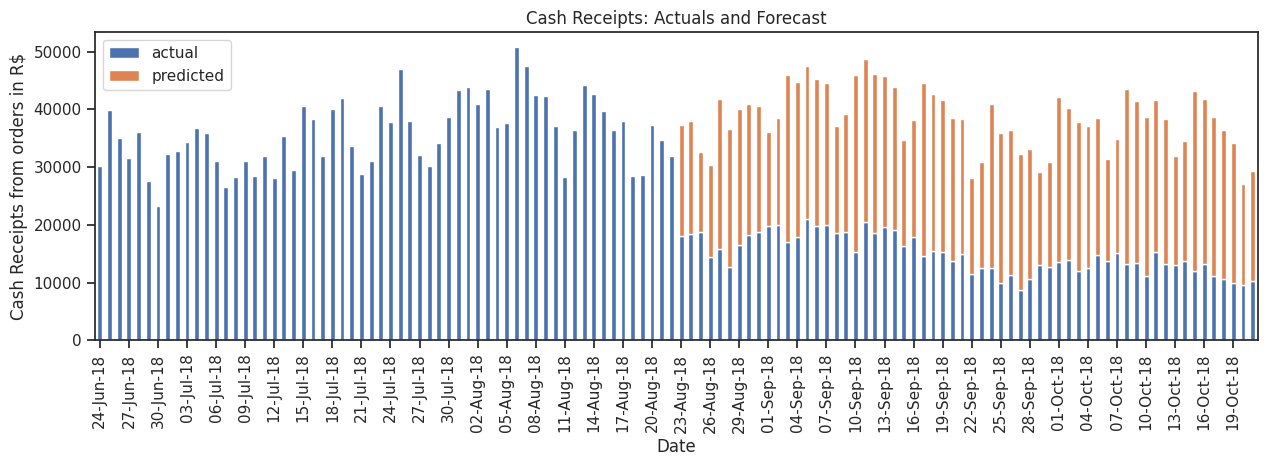

In [ ]:
# Plotting the stacked bar chart
last_date_to_plot = datetime.date(2018, 8, 22) + datetime.timedelta(days=60)
to_plot = actuals_forecast_df[['cash_receipt', 'actual','predicted']].query('cash_receipt <= @last_date_to_plot'); to_plot.set_index('cash_receipt', inplace=True)

fig, ax = plt.subplots();
to_plot = to_plot.iloc[-120:]
to_plot.plot(kind='bar', stacked=True, ax=ax)

ax.set_ylabel('Cash Receipts from orders in R$')
ax.set_xlabel('Date')
ax.set_title('Cash Receipts: Actuals and Forecast')

ax.set_xticklabels([datetime.datetime.strftime(i, "%d-%b-%y") for i in to_plot.index])
ax.xaxis.set_major_locator(MultipleLocator(3))
plt.show()

#### KPIs for Business Insight

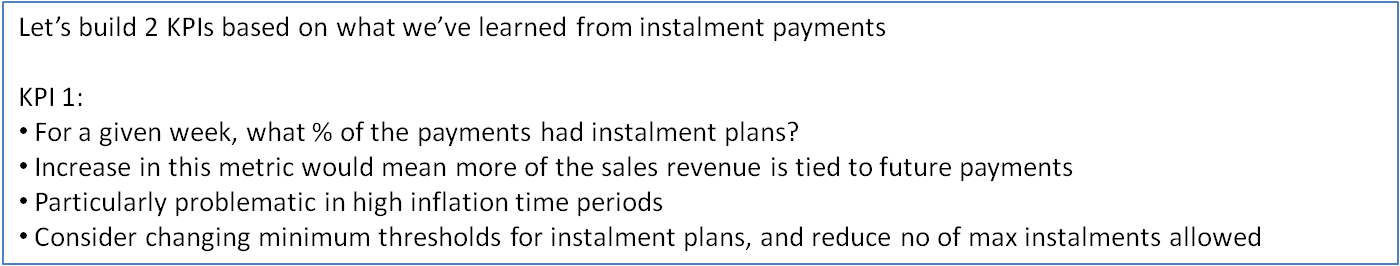

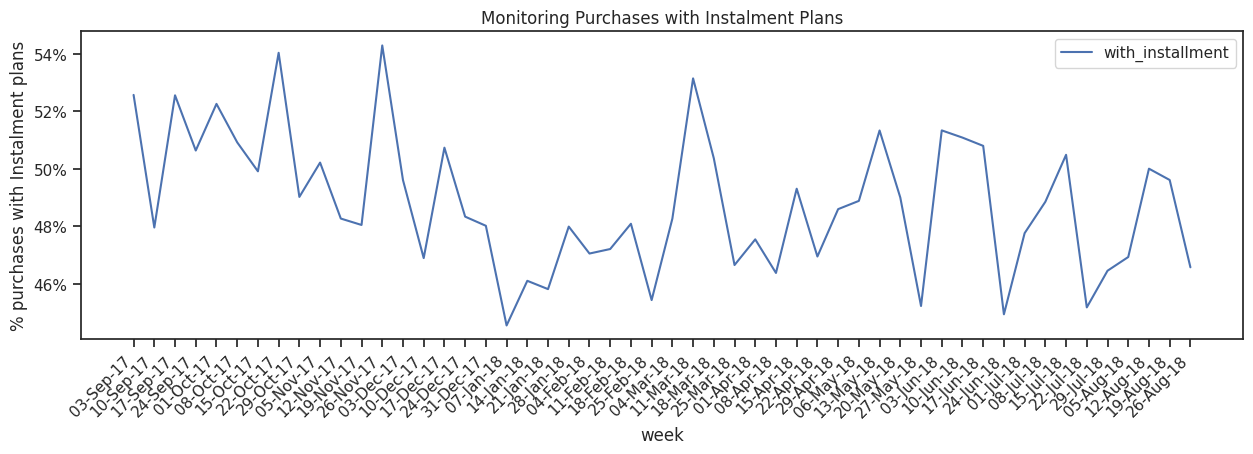

In [ ]:
monitor_instal_df = payment_lines_df.copy()
monitor_instal_df['with_installment'] = monitor_instal_df['payment_installments'].apply(lambda x: 1 if x>=2 else 0)
monitor_instal_df['week'] = monitor_instal_df['order_purchase_timestamp'].apply(lambda x: (x - datetime.timedelta(days=x.weekday()) + datetime.timedelta(days=6)).date())
monitor_instal_df = monitor_instal_df[['week', 'with_installment']].groupby('week').mean().reset_index(); monitor_instal_df.set_index('week', inplace=True)

fig, ax = plt.subplots();
monitor_instal_df = monitor_instal_df.iloc[-52:]
monitor_instal_df.plot(kind='line', ax=ax)

ax.set_ylabel('% purchases with Instalment plans')
ax.set_xlabel('week')
ax.set_title('Monitoring Purchases with Instalment Plans')

vals = ax.get_yticks(); ax.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax.set_xticks([datetime.datetime.strftime(i, "%d-%b-%y") for i in monitor_instal_df.index], [datetime.datetime.strftime(i, "%d-%b-%y") for i in monitor_instal_df.index], rotation=45, ha='right')

plt.show()

Trend isn't increasing - that's a good sign but keep monitoring

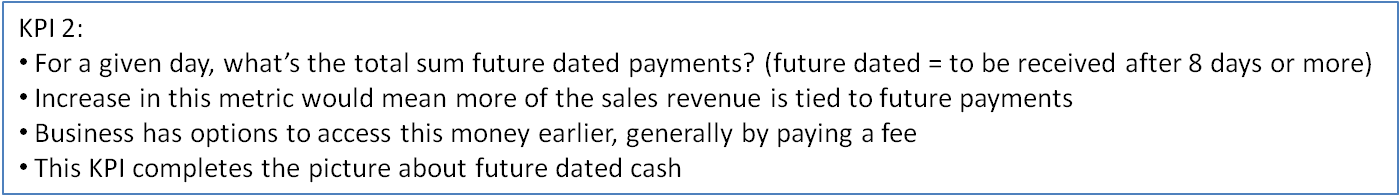

In [ ]:
#Calculate from the data
monitor_future_cash_val_df = payment_plan_df.copy()
future_dated_sum =[]; date_index=[]

#for i in pd.date_range(datetime.date(2016, 9, 4), datetime.date(2018, 8, 22), freq='D'):
for i in pd.date_range(datetime.date(2018, 8, 22) - datetime.timedelta(days=90), periods=91, freq='D'):
  date_index.append(i)
  reference = i + datetime.timedelta(7)
  future_dated_sum.append(monitor_future_cash_val_df.query('cash_receipt >@reference and purchase_date<@i')['payment_value'].sum())

future_dated_sum_df = pd.DataFrame({'future_dated_sum': future_dated_sum}, index = date_index)

In [ ]:
# Power BI Extract
#future_dated_sum_df.index = pd.to_datetime(future_dated_sum_df.index)
#future_dated_sum_df.columns = ['Future Dated Payments Total R$']
#future_dated_sum_df.to_csv('/content/gdrive/MyDrive/Data_Scientist_Case/future_dated.csv')

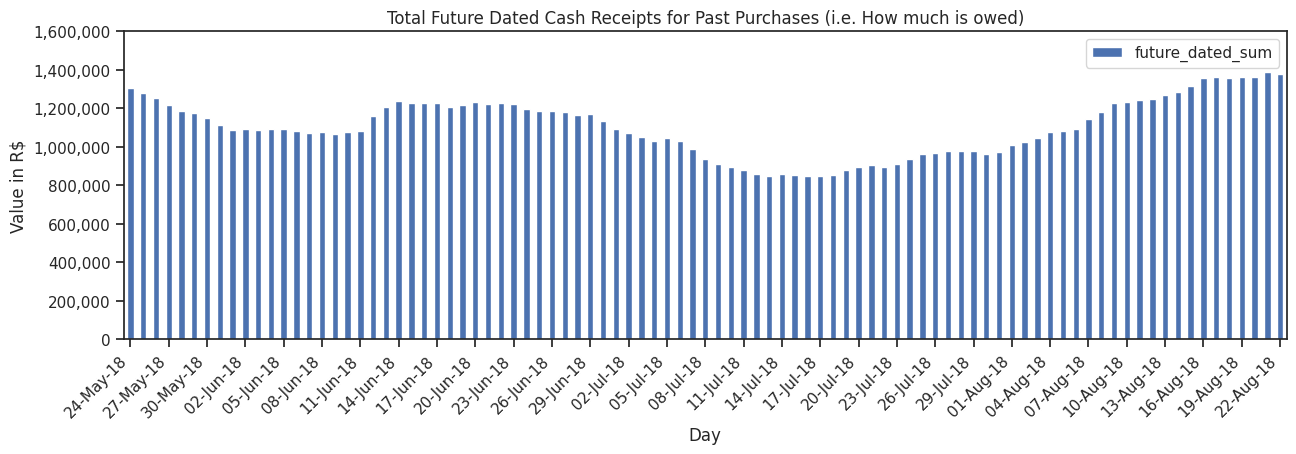

In [ ]:
fig, ax = plt.subplots();
future_dated_sum_df.plot(kind='bar', ax=ax)

ax.set_ylabel('Value in R$')
ax.set_xlabel('Day')
ax.set_title('Total Future Dated Cash Receipts for Past Purchases (i.e. How much is owed)')

vals = ax.get_yticks(); ax.set_yticklabels(['{:,.0f}'.format(x) for x in vals])
tickvalues = range(0,len(future_dated_sum_df.index))
ax.set_xticks(ticks = tickvalues,labels =[datetime.datetime.strftime(i, "%d-%b-%y") for i in list(future_dated_sum_df.index)], rotation=45, ha='right')
ax.xaxis.set_major_locator(MultipleLocator(3))
ax.set_ylim([1200000, 1600000])

plt.show()

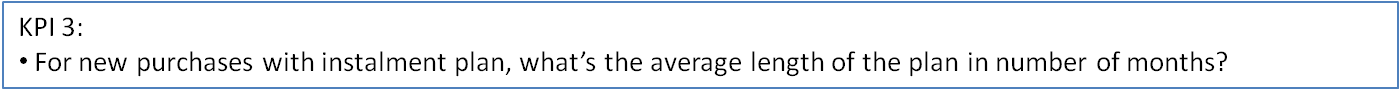

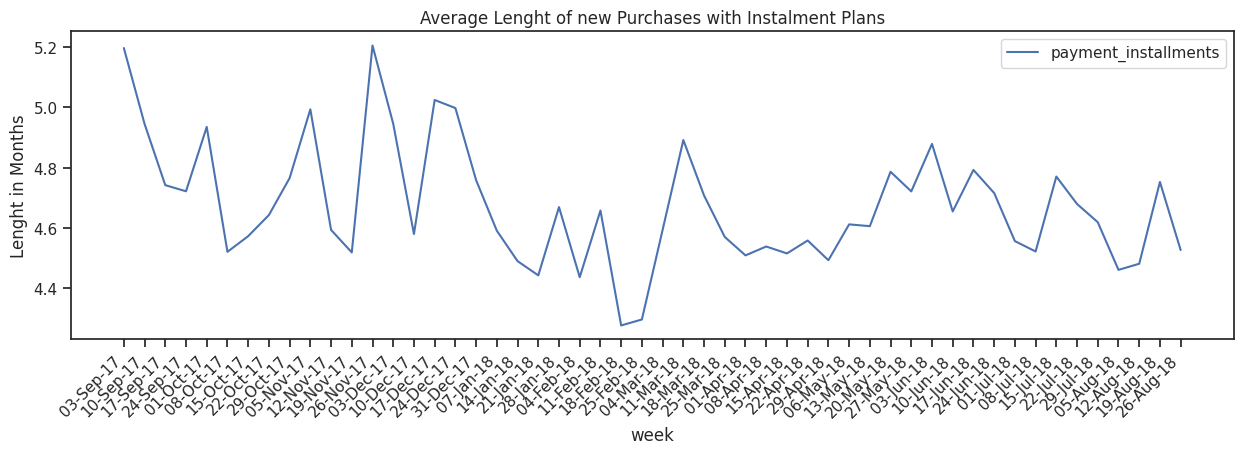

In [ ]:
# Get the data ready for the KPI
avg_instal_lenght_df = payment_lines_df[payment_lines_df['payment_installments'] >= 2].copy()
avg_instal_lenght_df['week'] = avg_instal_lenght_df['order_purchase_timestamp'].apply(lambda x: (x - datetime.timedelta(days=x.weekday()) + datetime.timedelta(days=6)).date())
avg_instal_lenght_df = avg_instal_lenght_df[['week', 'payment_installments']].groupby('week').mean()

fig, ax = plt.subplots();
avg_instal_lenght_df = avg_instal_lenght_df.iloc[-52:]
avg_instal_lenght_df.plot(kind='line', ax=ax)

ax.set_ylabel('Lenght in Months')
ax.set_xlabel('week')
ax.set_title('Average Lenght of new Purchases with Instalment Plans')

vals = ax.get_yticks(); ax.set_yticklabels(['{:.1f}'.format(x) for x in vals])
ax.set_xticks([datetime.datetime.strftime(i, "%d-%b-%y") for i in avg_instal_lenght_df.index], [datetime.datetime.strftime(i, "%d-%b-%y") for i in avg_instal_lenght_df.index], rotation=45, ha='right')

plt.show()

Average Instalment Plans are mostly flat

In [ ]:
#PowerBI_Export
#export_df = monitor_instal_df.merge(avg_instal_lenght_df, left_index=True, right_index=True, how='outer')
#export_df.columns=['With Instalment Plan %','Avg Number of Instalments']; export_df.to_csv(r'/content/gdrive/MyDrive/Data_Scientist_Case/instalment_KPIs.csv')

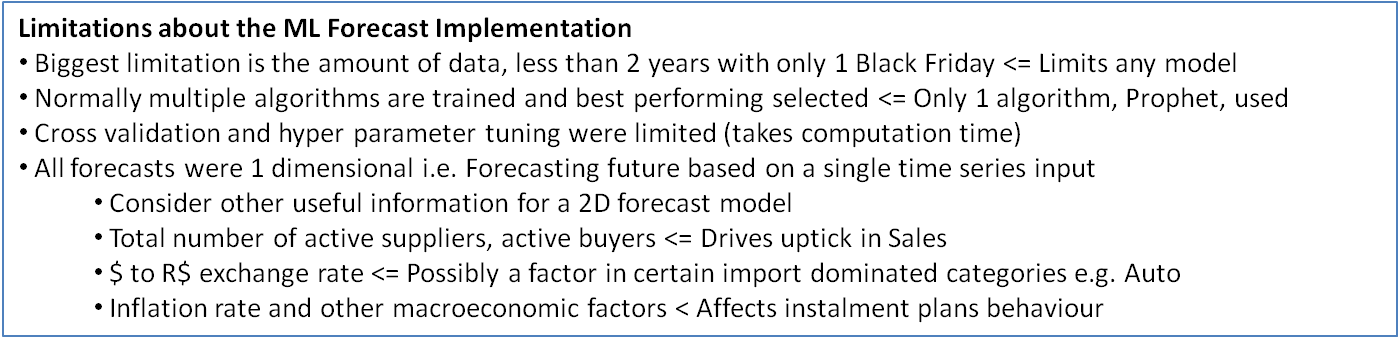

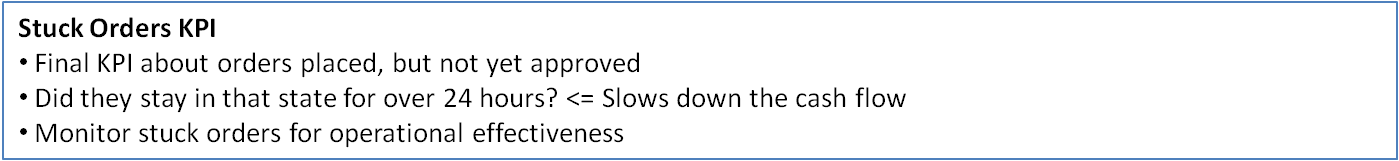

In [ ]:
orders_stuck_KPI = orders.copy(); orders_stuck_KPI= orders_stuck_KPI[~orders_stuck_KPI['order_approved_at'].isna()]
orders_stuck_KPI['orders_stuck'] = orders_stuck_KPI.apply(lambda x: 1 if ((x['order_approved_at'] - x['order_purchase_timestamp']).total_seconds() / (24*60*60)) >= 1 else 0, axis=1)
orders_stuck_KPI['week'] = orders_stuck_KPI['order_purchase_timestamp'].apply(lambda x: (x - datetime.timedelta(days=x.weekday()) + datetime.timedelta(days=6)).date())

In [ ]:
#Power BI Extract
#orders_stuck_KPI[['week', 'orders_stuck']].to_csv(r'/content/gdrive/MyDrive/Data_Scientist_Case/orders_stuck.csv')